In [130]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 250
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')

In [131]:
#read the data
df = pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# EDA

In [132]:
#Describe the data
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [133]:
#Null values
df.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [134]:
#Number of duplicate values
df.duplicated().sum()

0

# Multicollinearity: 
    1.Saccterplot matrix 
    2.Correlation
    3.VIF

Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Correlation between independent columns should be low and Correlation between dependent and indepedent column should be high

# Visualization

<AxesSubplot:>

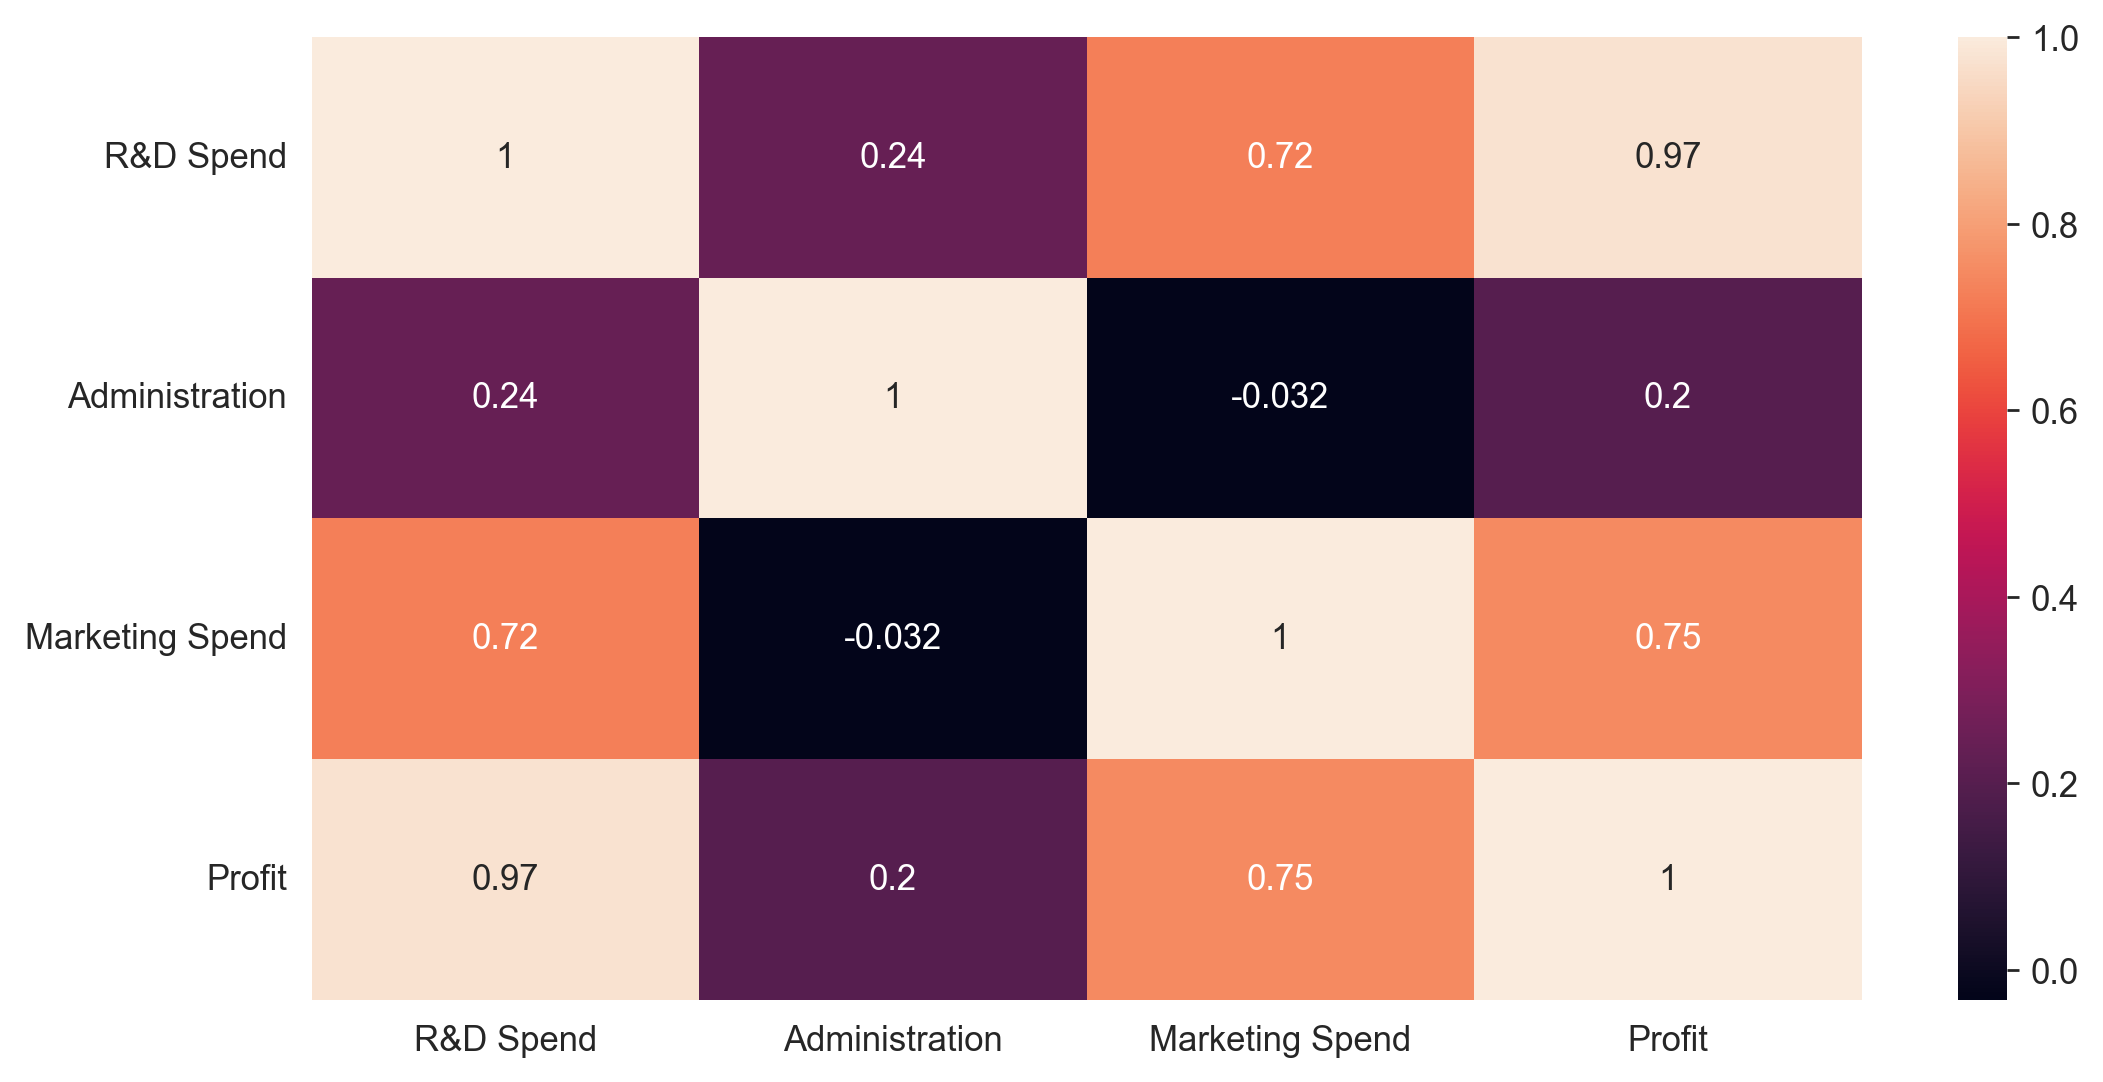

In [135]:
#Finding correlation between the columns using heatmap
sns.heatmap(df.corr(), annot=True)

The correlation between R&D Spend and Profit is 0.97 (between independent and dependent column). We don't see any multicollinearity in data

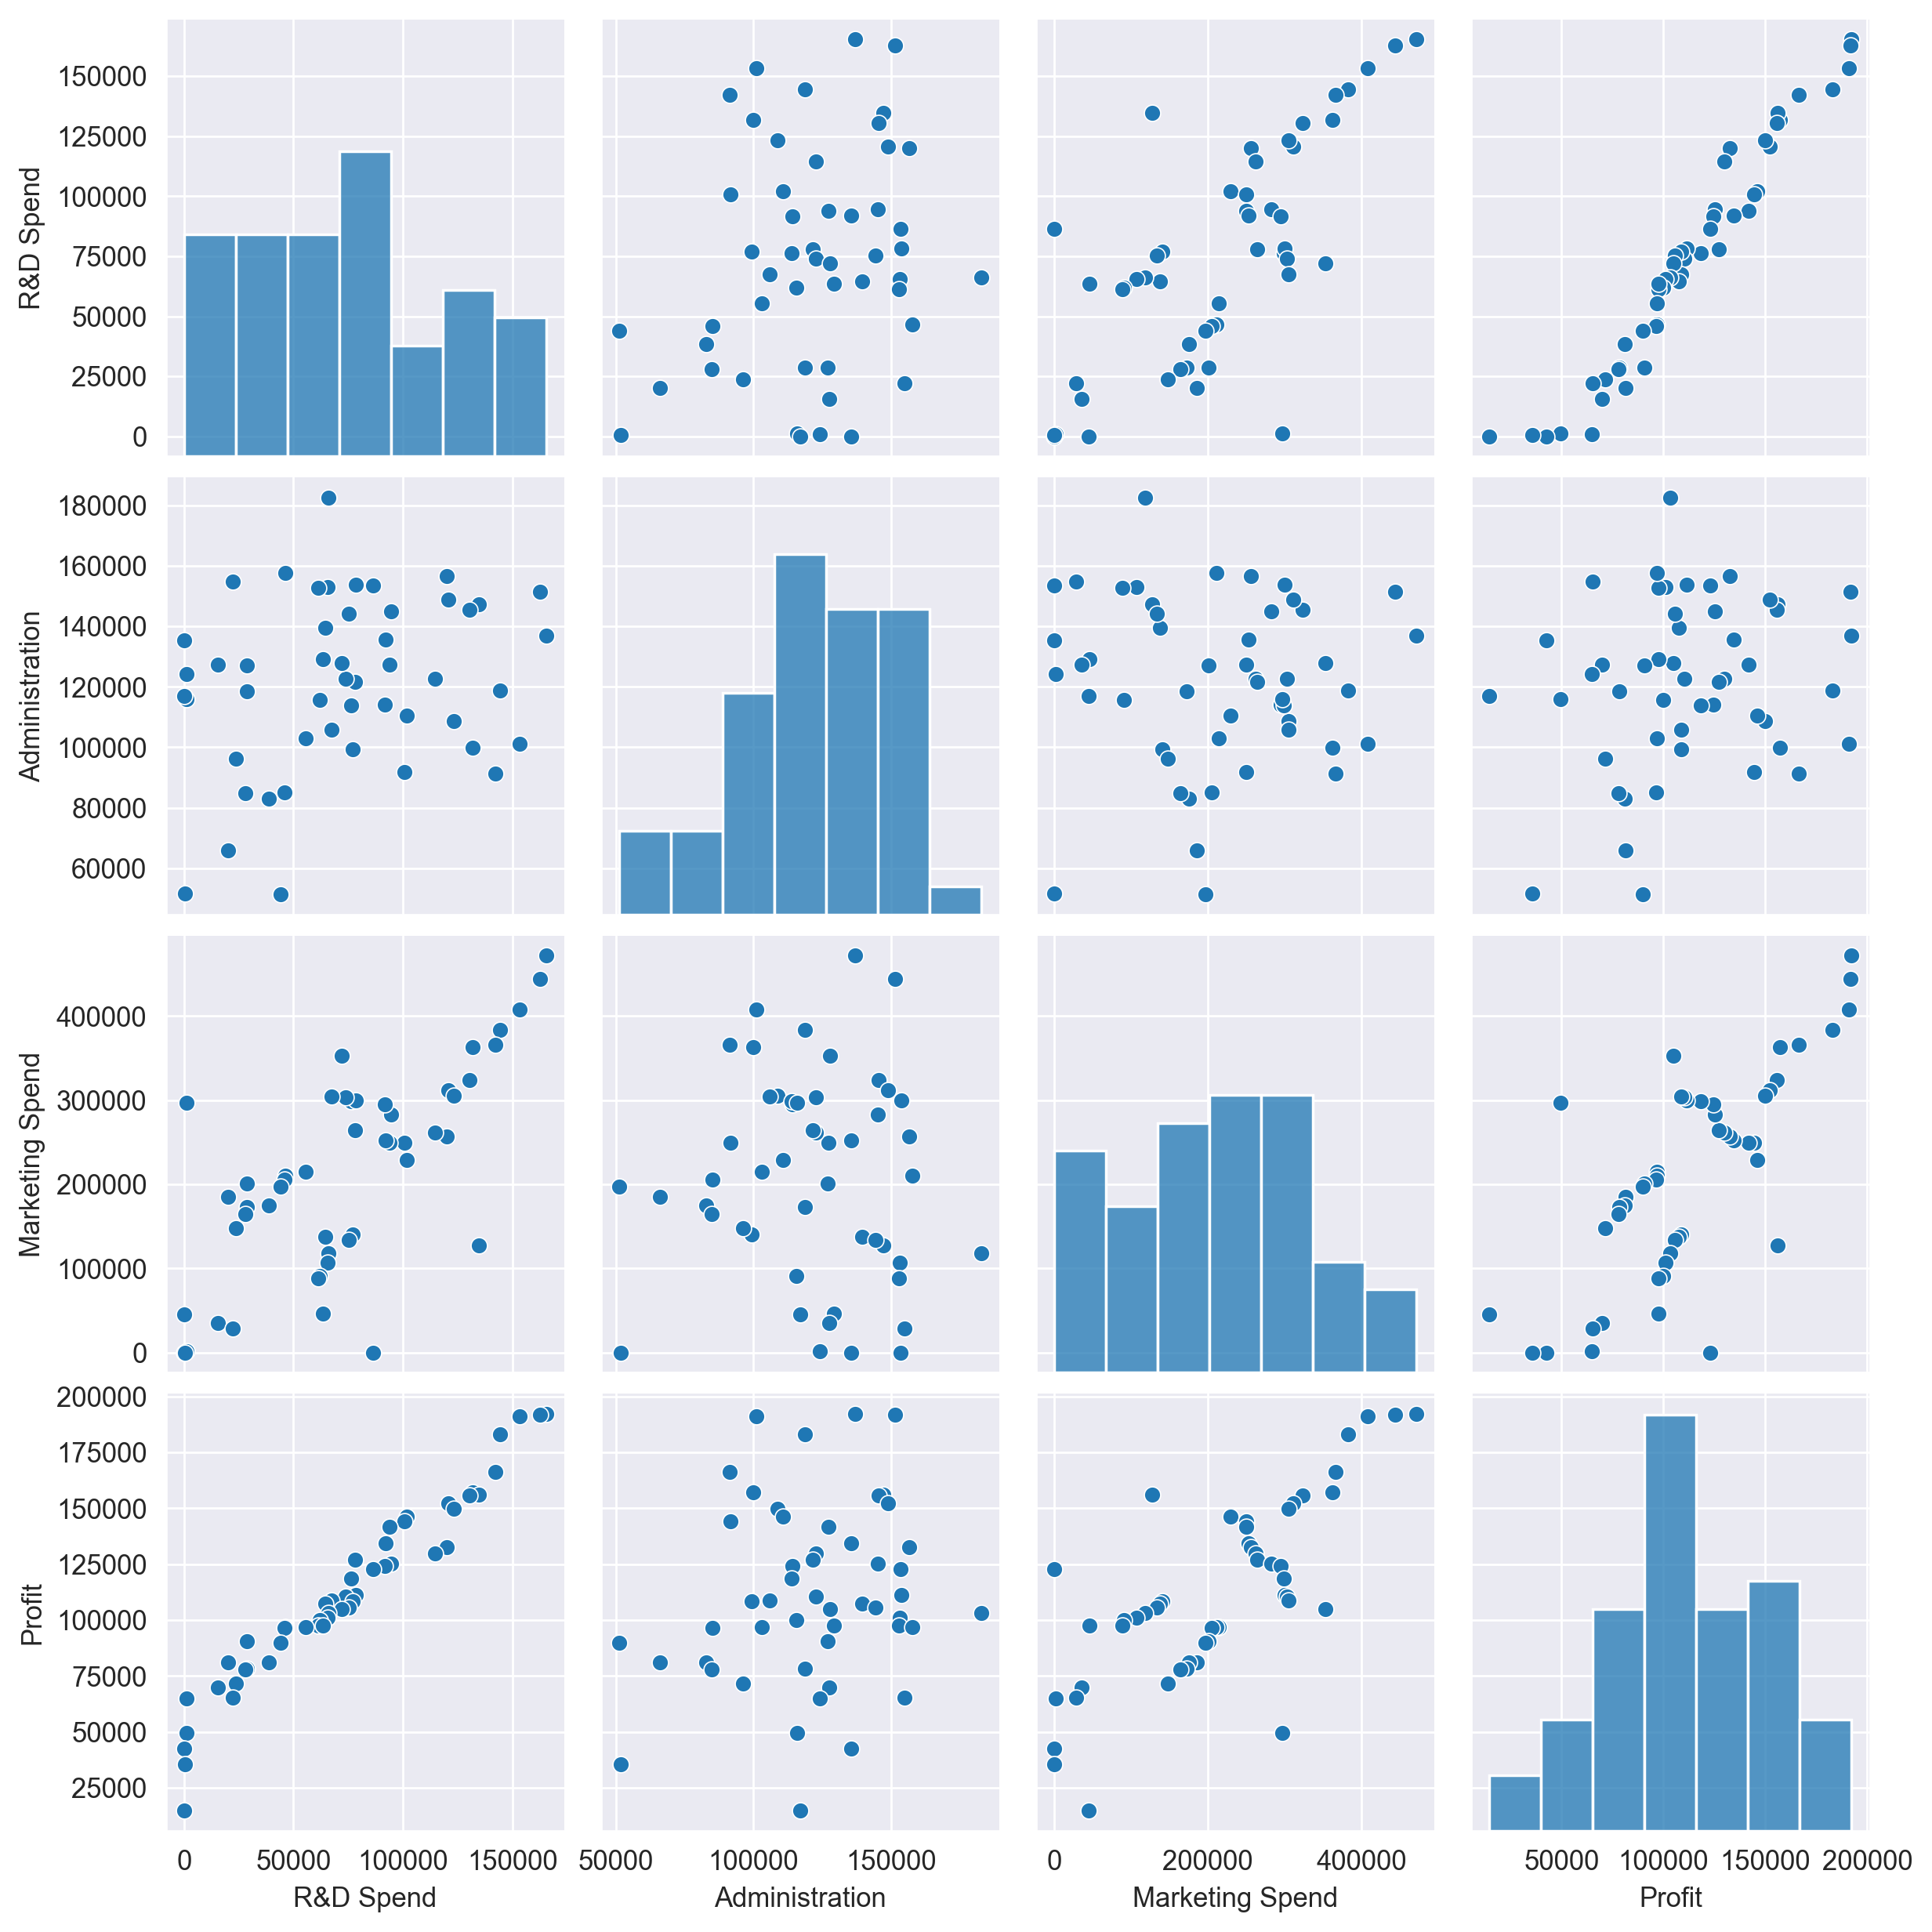

In [136]:
sns.pairplot(df)

<AxesSubplot:>

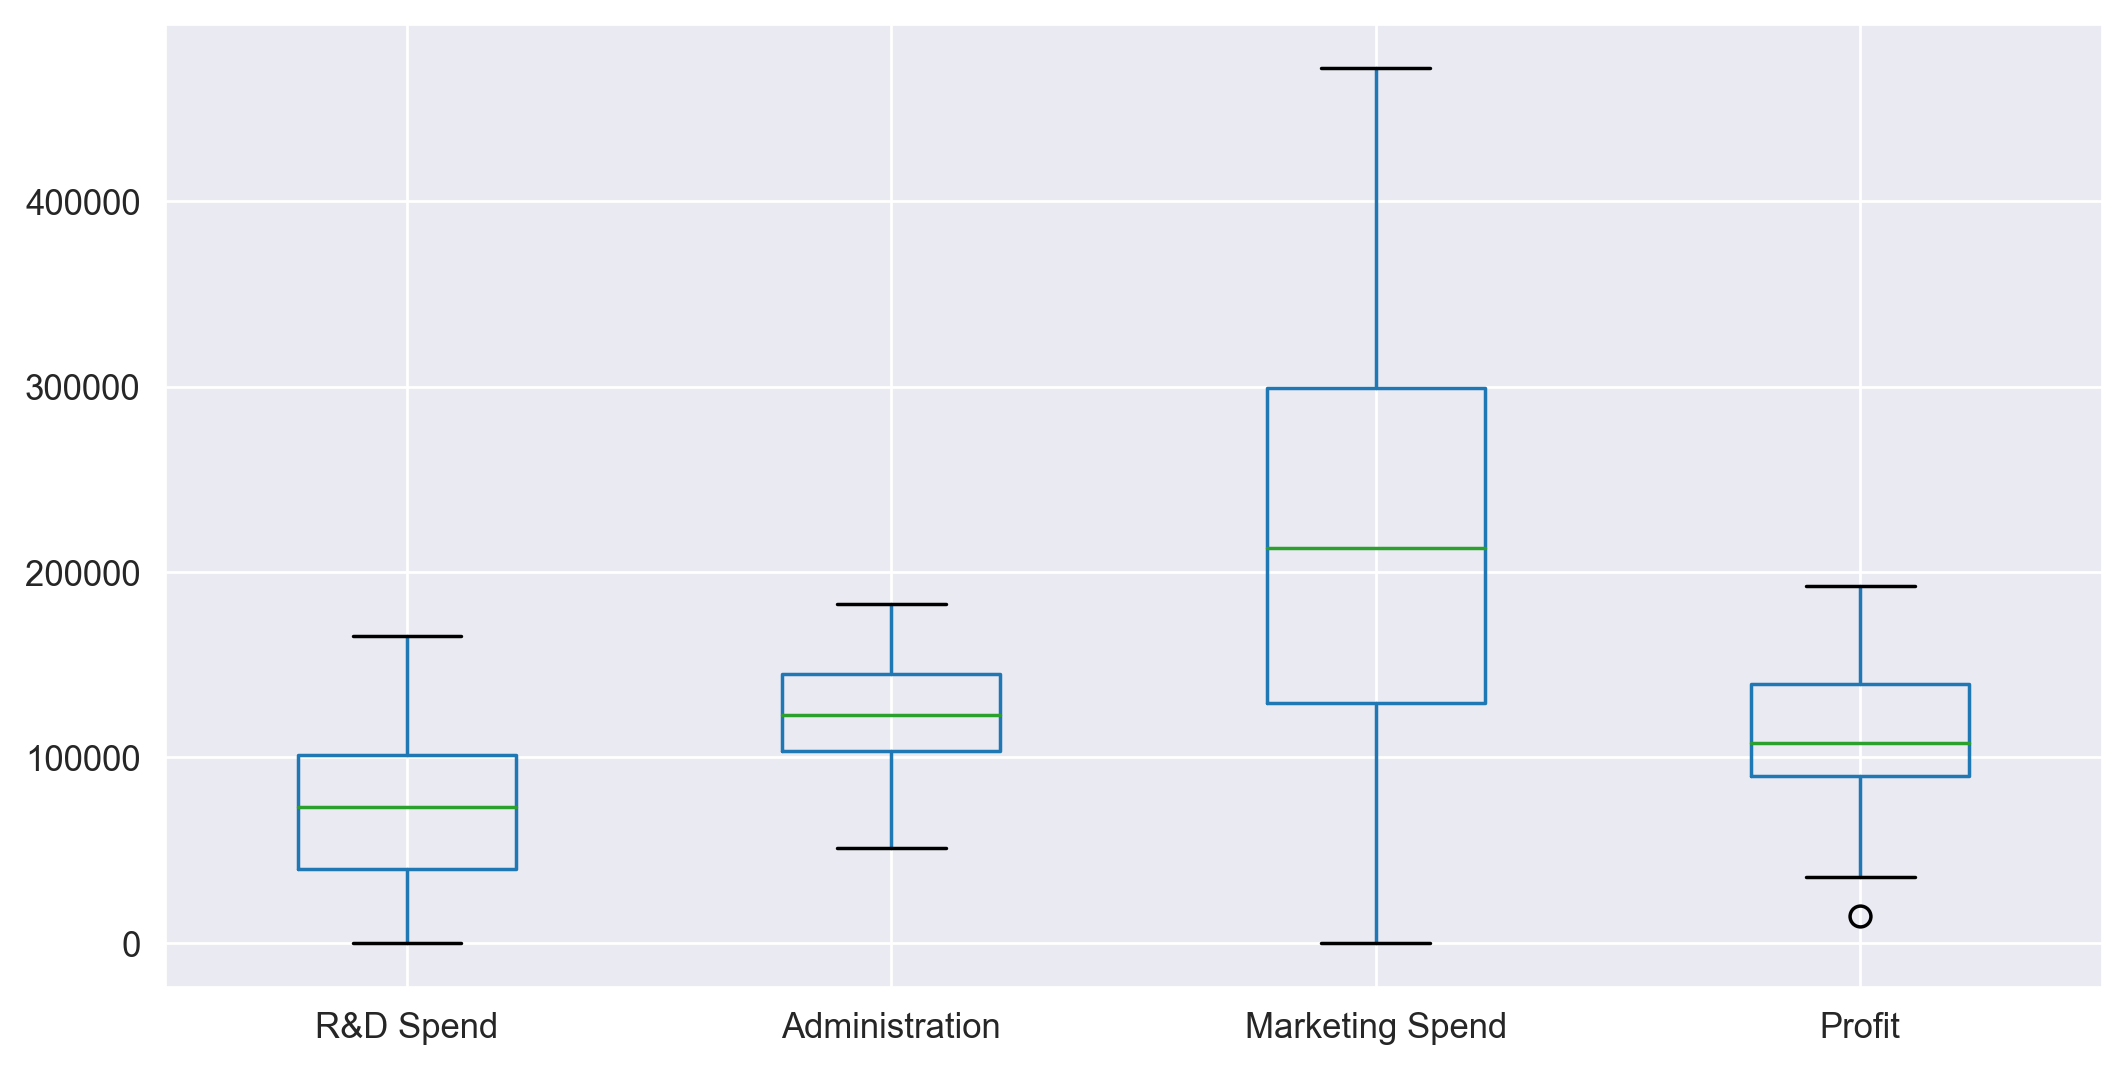

In [137]:
df.boxplot()

Profit column has one outlier below lower extreme

# Replacing outlier with capping technique

In [138]:
#Function for outlier detection
def outlier_detection(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr=q3-q1
    
    upper= q3+(1.5*iqr)
    lower= q1-(1.5*iqr)
    
    return lower,upper

In [139]:
#printing all the upper and lower values for column- Profit
print('Profit: ',outlier_detection(df,'Profit'))

Profit:  (15698.290000000023, 214206.58999999997)


In [140]:
df.loc[df['Profit']<15698.290000000023,'Profit'] = 15698.290000000023
df.loc[df['Profit']>214206.58999999997,'Profit'] = 214206.58999999997

<AxesSubplot:xlabel='Profit'>

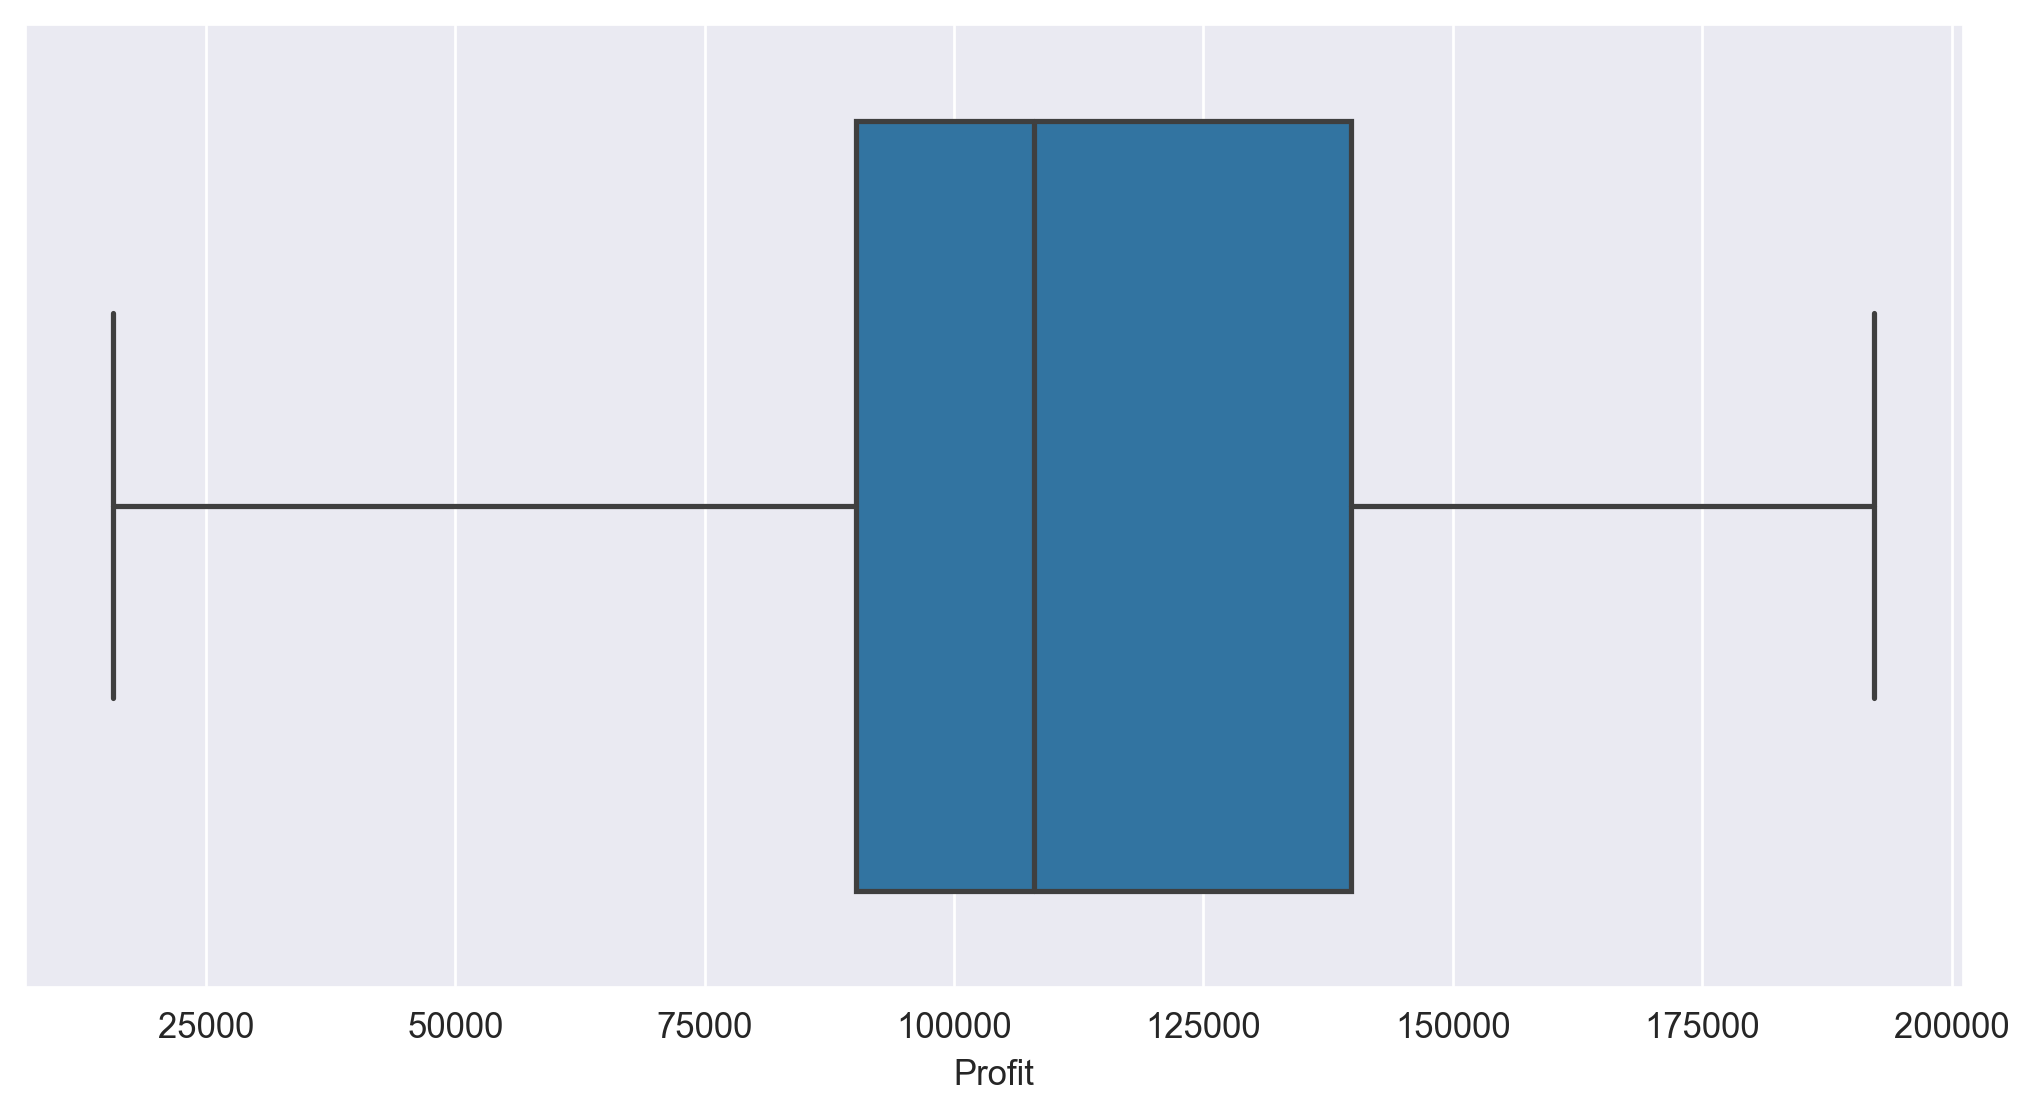

In [141]:
sns.boxplot(df['Profit'])

In [142]:
#Rename the columns
df.rename(columns={'R&D Spend':'RDSpend','Marketing Spend':'MarketSpend'},inplace=True)
# using label.encoding for State 
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df["State"]=lb.fit_transform(df["State"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RDSpend         50 non-null     float64
 1   Administration  50 non-null     float64
 2   MarketSpend     50 non-null     float64
 3   State           50 non-null     int32  
 4   Profit          50 non-null     float64
dtypes: float64(4), int32(1)
memory usage: 1.9 KB


# For more understanding I am doing this check:
    Using hypothesis testing: 
        H0: m=0, Ha: m≠0,
        lets consider α=0.05, then if p<α->Reject H0 else fail to reject nul  hypothesis

In [143]:
import statsmodels.formula.api as smf
model = smf.ols('Profit~RDSpend+Administration+MarketSpend+State',data=df).fit()

In [144]:
model.pvalues

Intercept         2.233244e-09
RDSpend           6.032751e-22
Administration    6.041473e-01
MarketSpend       1.063643e-01
State             9.760123e-01
dtype: float64

AIC: 
    1)Number of rows high and number of columns are optimal.
    2)To check multicollinearity, the rsquared value should be high and aic value shold be low.

In [145]:
model.rsquared, model.aic

(0.9514716379797403, 1059.9055341151452)

# VIF

In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [147]:
df.head()

,RDSpend,Administration,MarketSpend,State,Profit
0,165349.20,136897.80,471784.10,2,192261.83
1,162597.70,151377.59,443898.53,0,191792.06
2,153441.51,101145.55,407934.54,1,191050.39
3,144372.41,118671.85,383199.62,2,182901.99
4,142107.34,91391.77,366168.42,1,166187.94


In [148]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]

In [149]:
vif

,VIF
0,30.748098
1,13.652432
2,9.861929
3,2.444179
4,82.194651


In [150]:
vif['features'] = df.columns
vif

,VIF,features
0,30.748098,RDSpend
1,13.652432,Administration
2,9.861929,MarketSpend
3,2.444179,State
4,82.194651,Profit


From above values there is no two independent columns have equal values. Hence there is no multicollinearity

# Model building

In [151]:
#Scale the data using Standard scalerRd
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
df[['RDSpend','Administration','MarketSpend','State','Profit']] = stdscaler.fit_transform(df)

In [152]:
df.head()

,RDSpend,Administration,MarketSpend,State,Profit
0,2.016411,0.560753,2.153943,1.212678,2.013185
1,1.955860,1.082807,1.923600,-1.212678,2.001397
2,1.754364,-0.728257,1.626528,0.000000,1.982787
3,1.554784,-0.096365,1.422210,1.212678,1.778319
4,1.504937,-1.079919,1.281528,0.000000,1.358912


In [153]:
# initialisisng x and y
x=df.iloc[:,:4]
y=df.iloc[:,:-1]

# splitting dataset into test and train
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=0)

# object creation and train the model
from sklearn.linear_model import LinearRegression

startModel=LinearRegression()
startModel.fit(xtrain,ytrain)

# Predicting the label

ytrainPredict=startModel.predict(xtrain)
ytestPredict=startModel.predict(xtest)

# Evaluating the output 
from sklearn.metrics import r2_score,mean_squared_error

r2scoretrain=r2_score(ytrain,ytrainPredict)
r2scoretest=r2_score(ytest,ytestPredict)

print("Coefficient of determination r2Score-train =",r2scoretrain)
print("Coefficient of determination r2Score-test =",r2scoretest)

meansquarederrortrain=mean_squared_error(ytrain,ytrainPredict)
meansquarederrortest=mean_squared_error(ytest,ytestPredict)

print("Mean Squared Error for train =",meansquarederrortrain)
print("Mean Squared Error for test =",meansquarederrortest)

Coefficient of determination r2Score-train = 1.0
Coefficient of determination r2Score-test = 1.0
Mean Squared Error for train = 2.9737621084203815e-31
Mean Squared Error for test = 2.9099533697741117e-31


# MODEL VALIDATION TECHNIQUES

# 1.Residual Analysis

In [154]:
#Statsmodel
import statsmodels.api as sm

In [155]:
model.resid

0      -168.820923
1      2624.744641
2      8939.255091
3      9281.485548
4     -5922.877784
5     -6519.339320
6     -2034.777739
7     -4254.708217
8       526.063752
9     -5159.780402
10    10610.033886
11     8637.062517
12    12439.579742
13     6761.481301
14   -16942.559452
15   -16265.391119
16    10014.253808
17    -4781.338317
18    -4752.374281
19     7160.961837
20     1772.924019
21    -5974.455045
22    -4369.833847
23    -1279.298364
24    -4782.828818
25     5087.004196
26    -4893.341021
27    -9365.344663
28     1585.964777
29     -776.142269
30      452.342406
31     -193.551140
32    -1657.881619
33    -1164.100846
34     7586.229238
35     5984.455543
36    15376.131211
37      251.752386
38    11535.144766
39    -2808.760789
40     3329.175424
41     2952.467881
42      781.540517
43     9577.752823
44      478.510803
45    17251.837200
46    -6729.462136
47    -4052.831456
48   -13514.099379
49   -32634.256370
dtype: float64

# Q-Q plot:
    Checking for normality

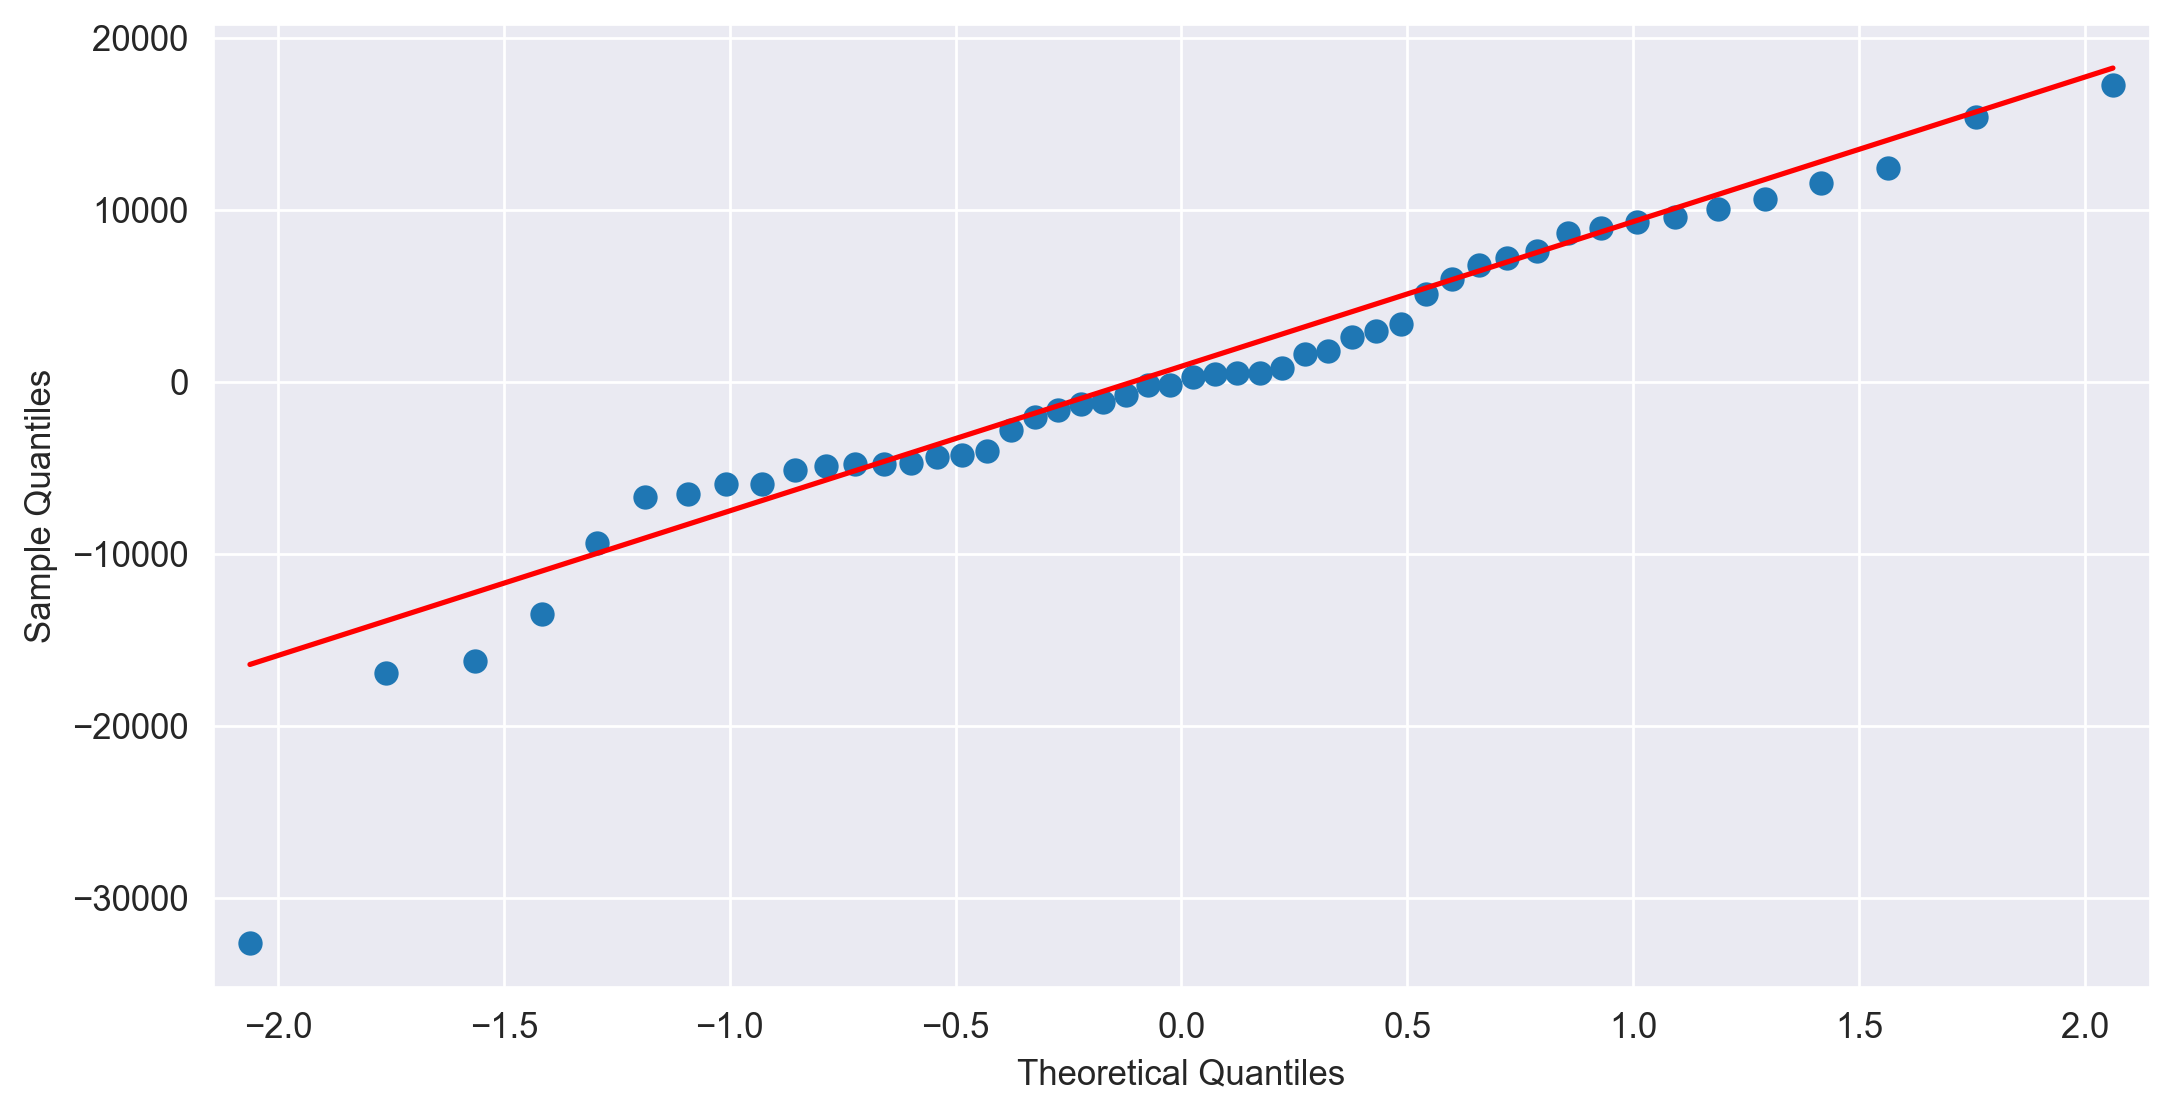

In [156]:
sm.qqplot(model.resid, line='q');

In [157]:
#get index for higher residuals
np.where(model.resid< -0.8)

(array([ 0,  4,  5,  6,  7,  9, 14, 15, 17, 18, 21, 22, 23, 24, 26, 27, 29,
        31, 32, 33, 39, 46, 47, 48, 49], dtype=int64),)

# 2. Residual plot of Homoscedasticity

-Homoscedasticity can be checked by plotting a scatter plot between fitted values and residuals.

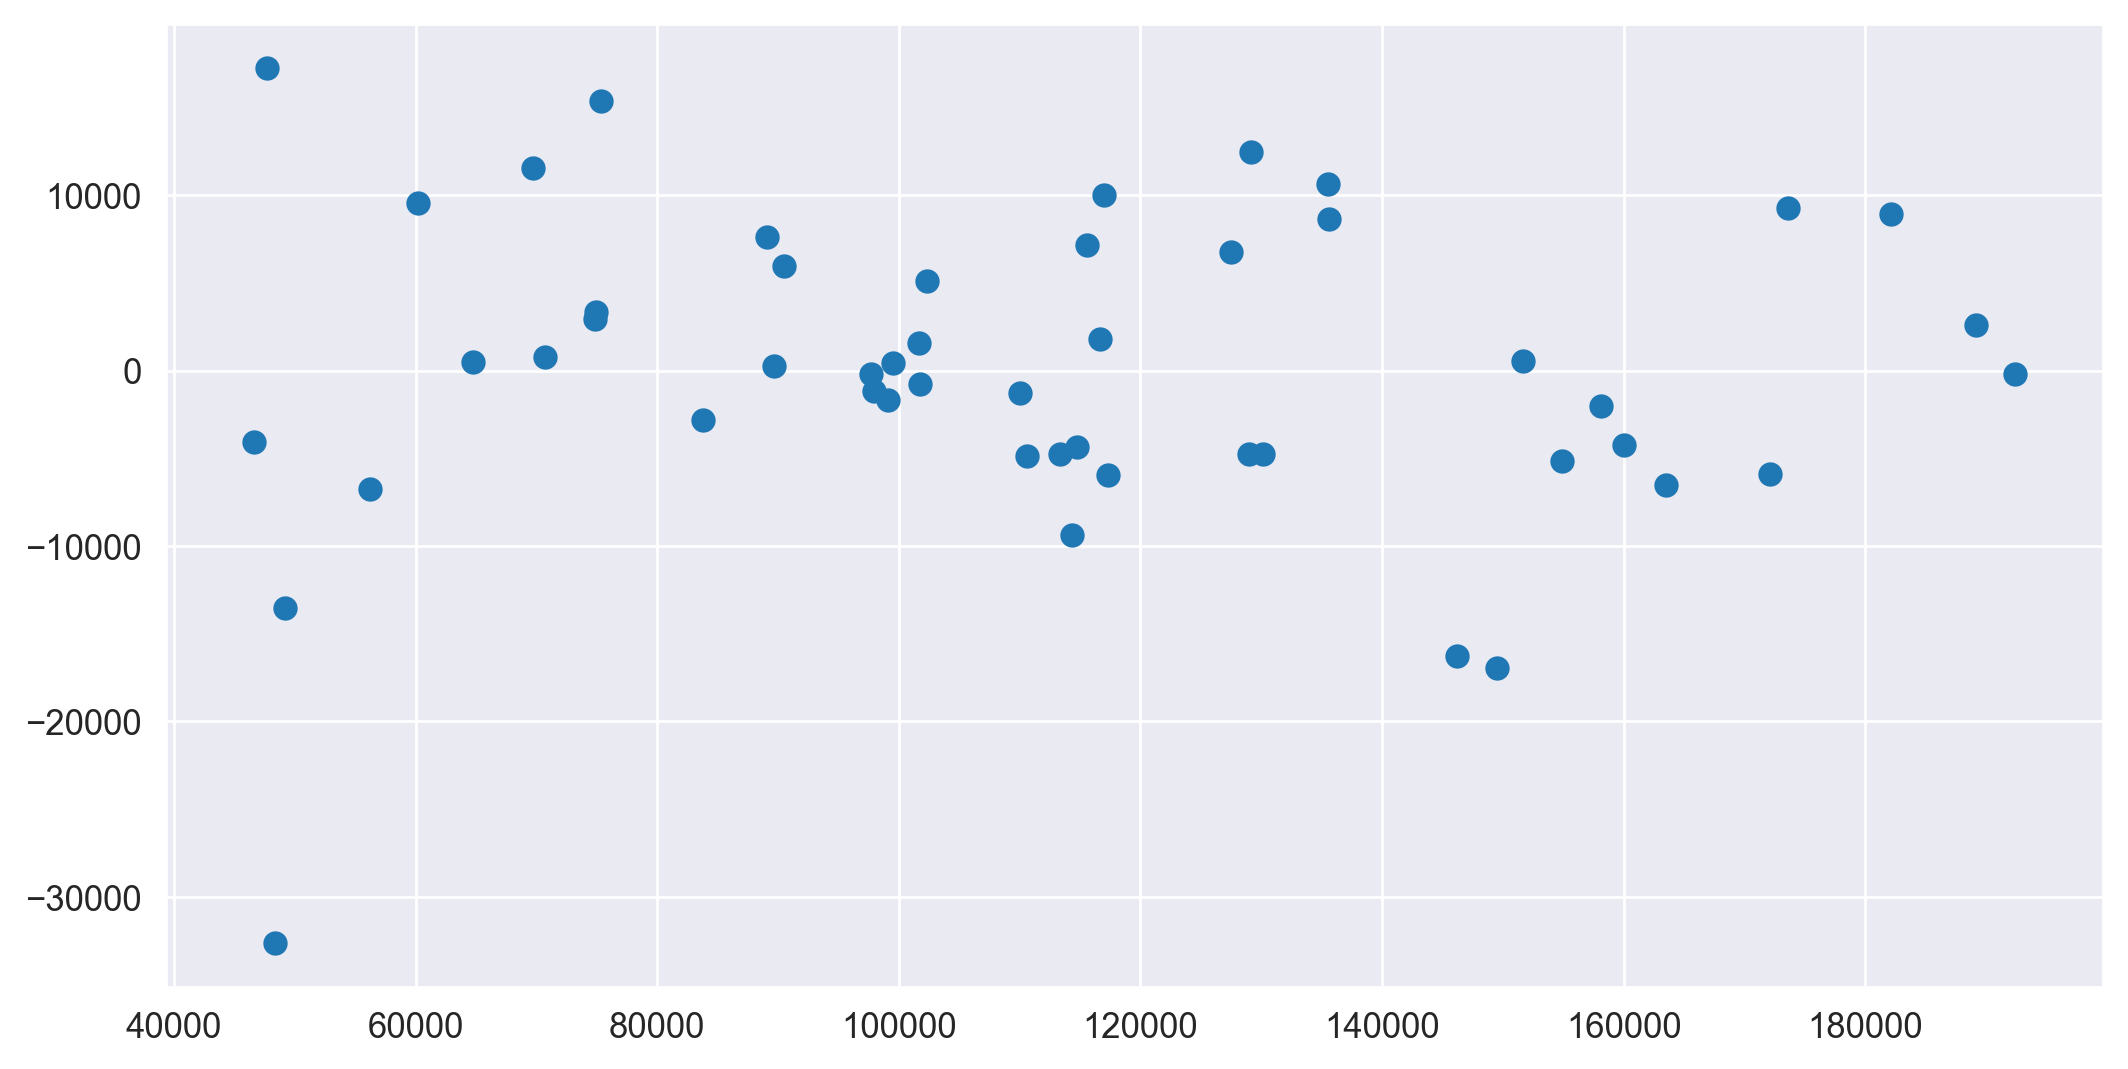

In [158]:
#No pattern then model is good
plt.scatter(model.fittedvalues,model.resid)

# 3.Residual VS Regressor:
    -Zero mean

eval_env: 1


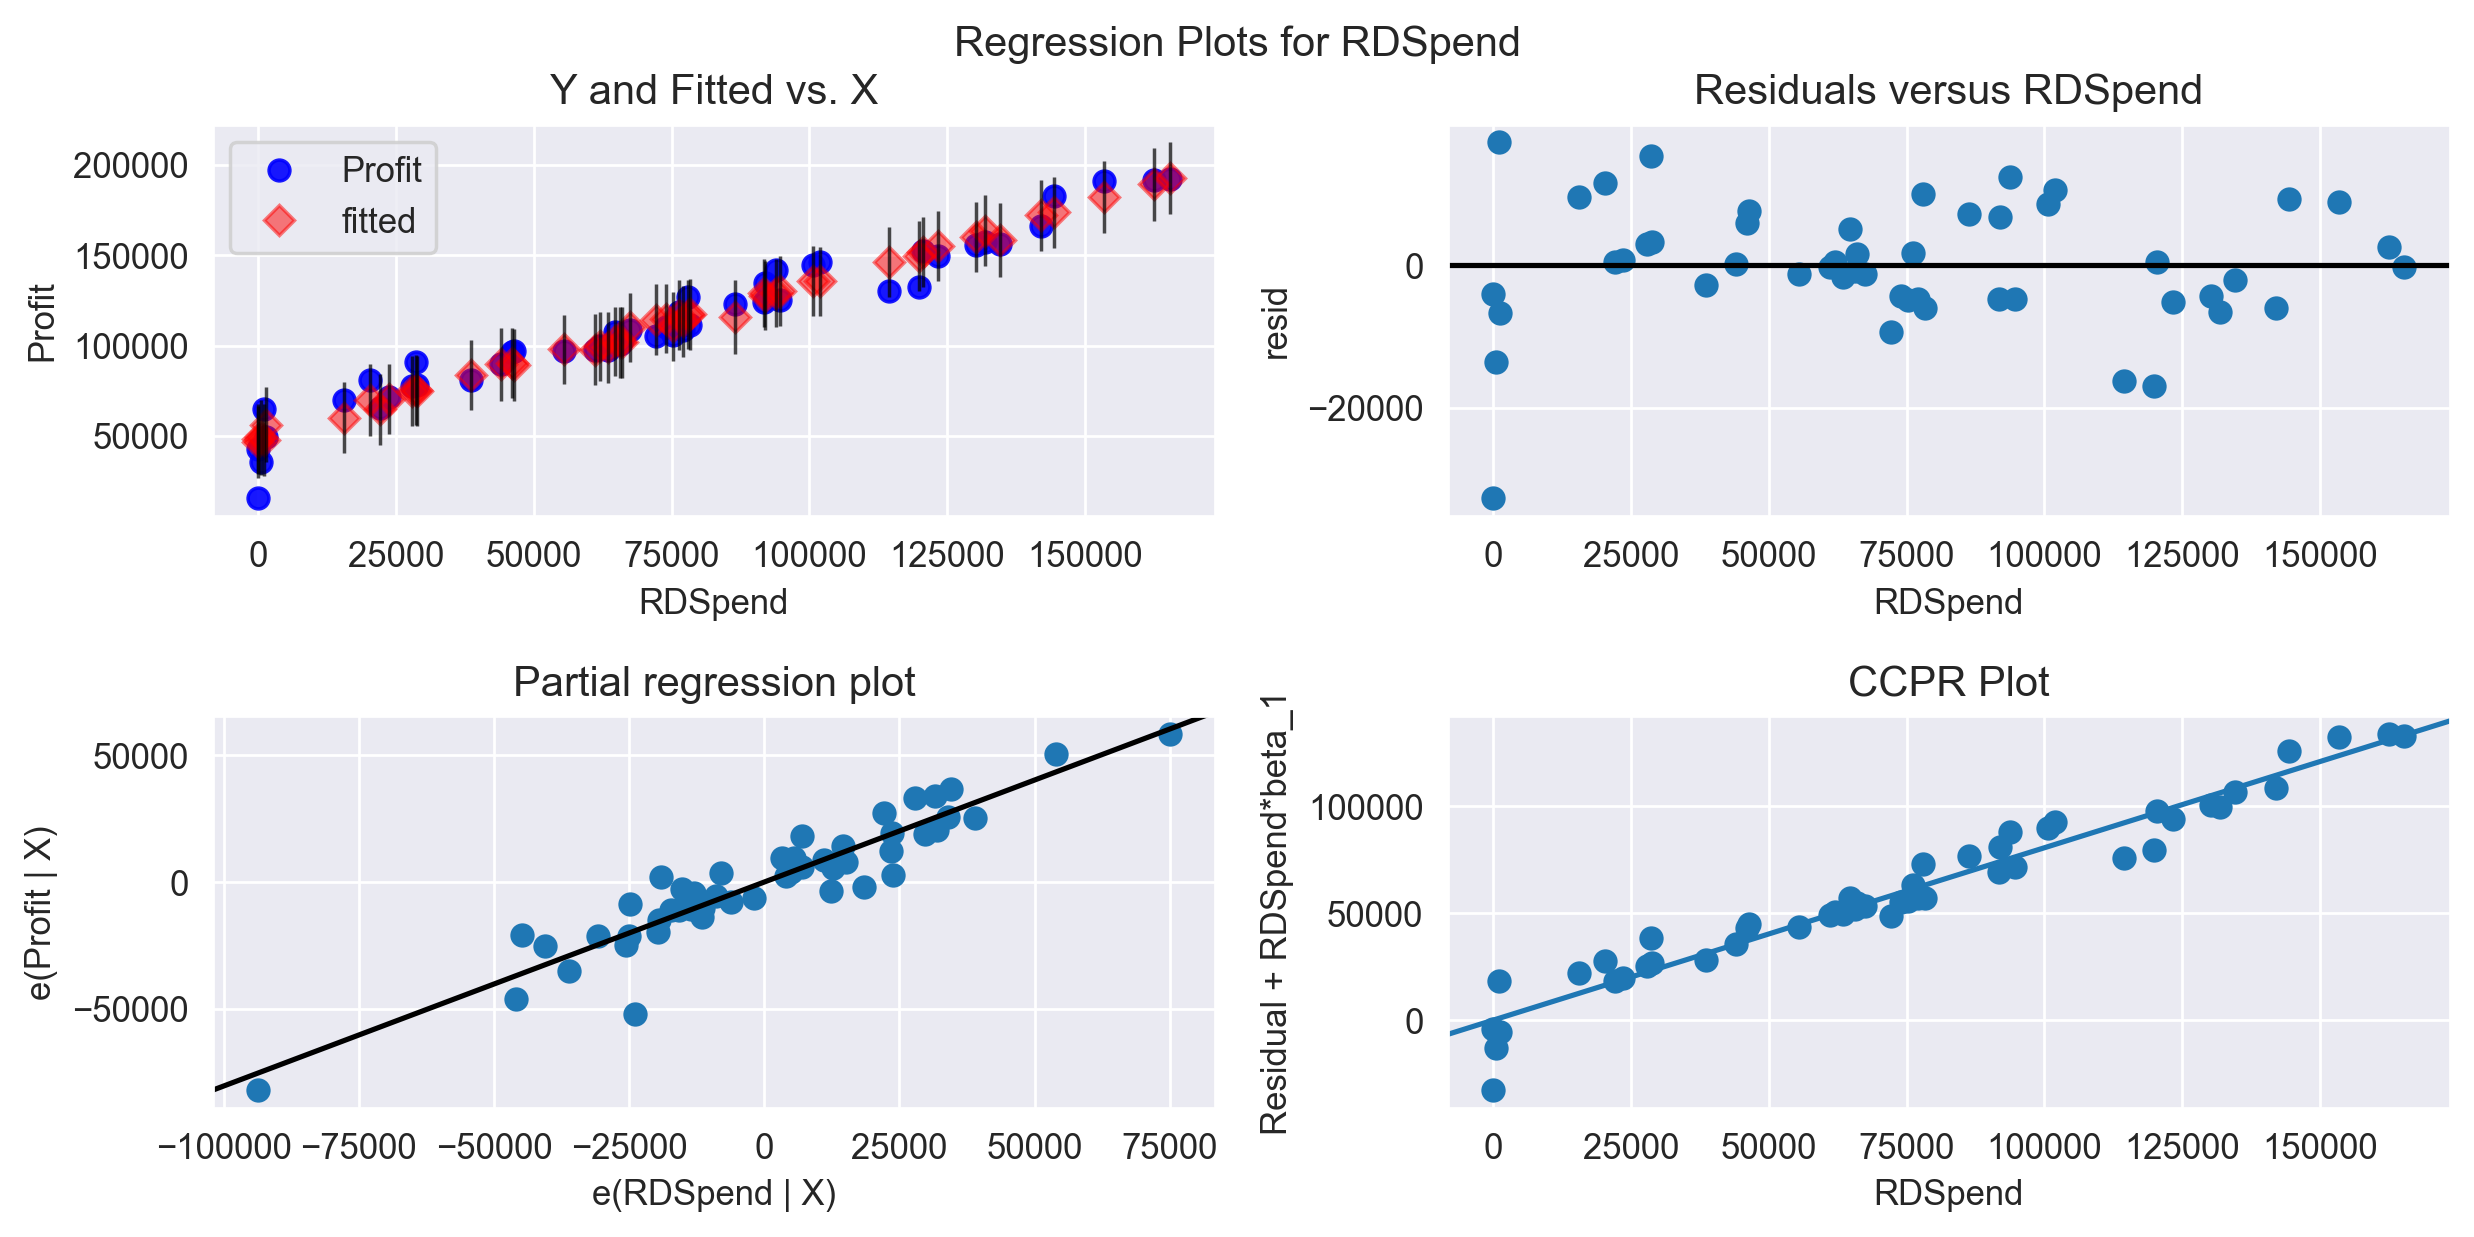

In [159]:
sm.graphics.plot_regress_exog(model,'RDSpend');

eval_env: 1


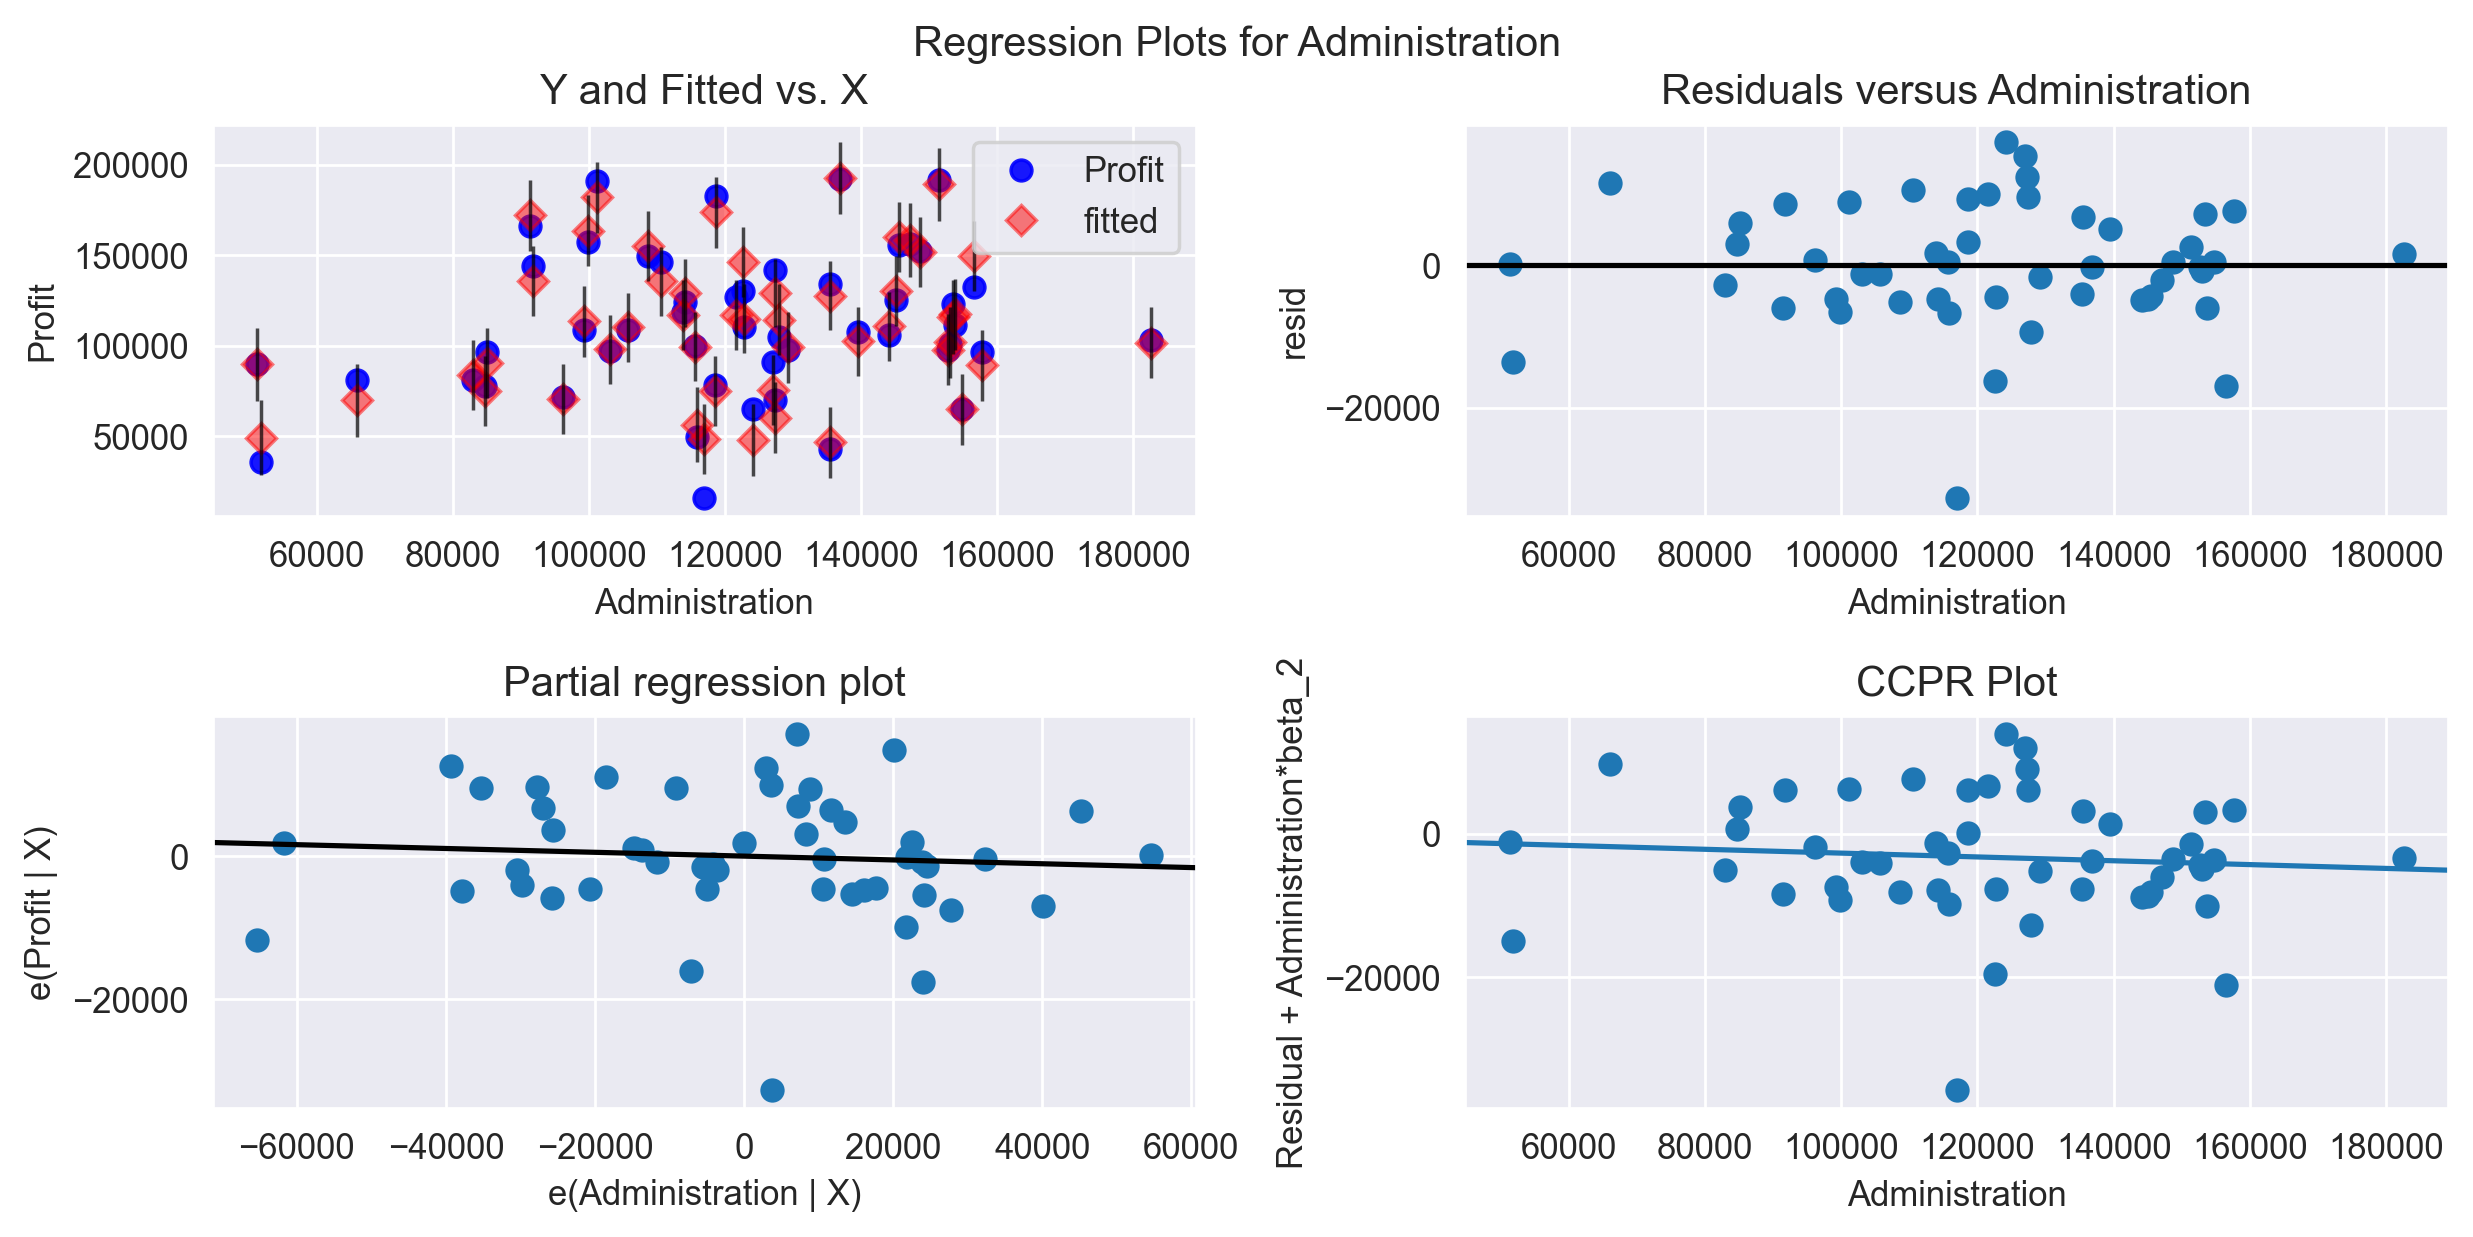

In [160]:
sm.graphics.plot_regress_exog(model,'Administration');

eval_env: 1


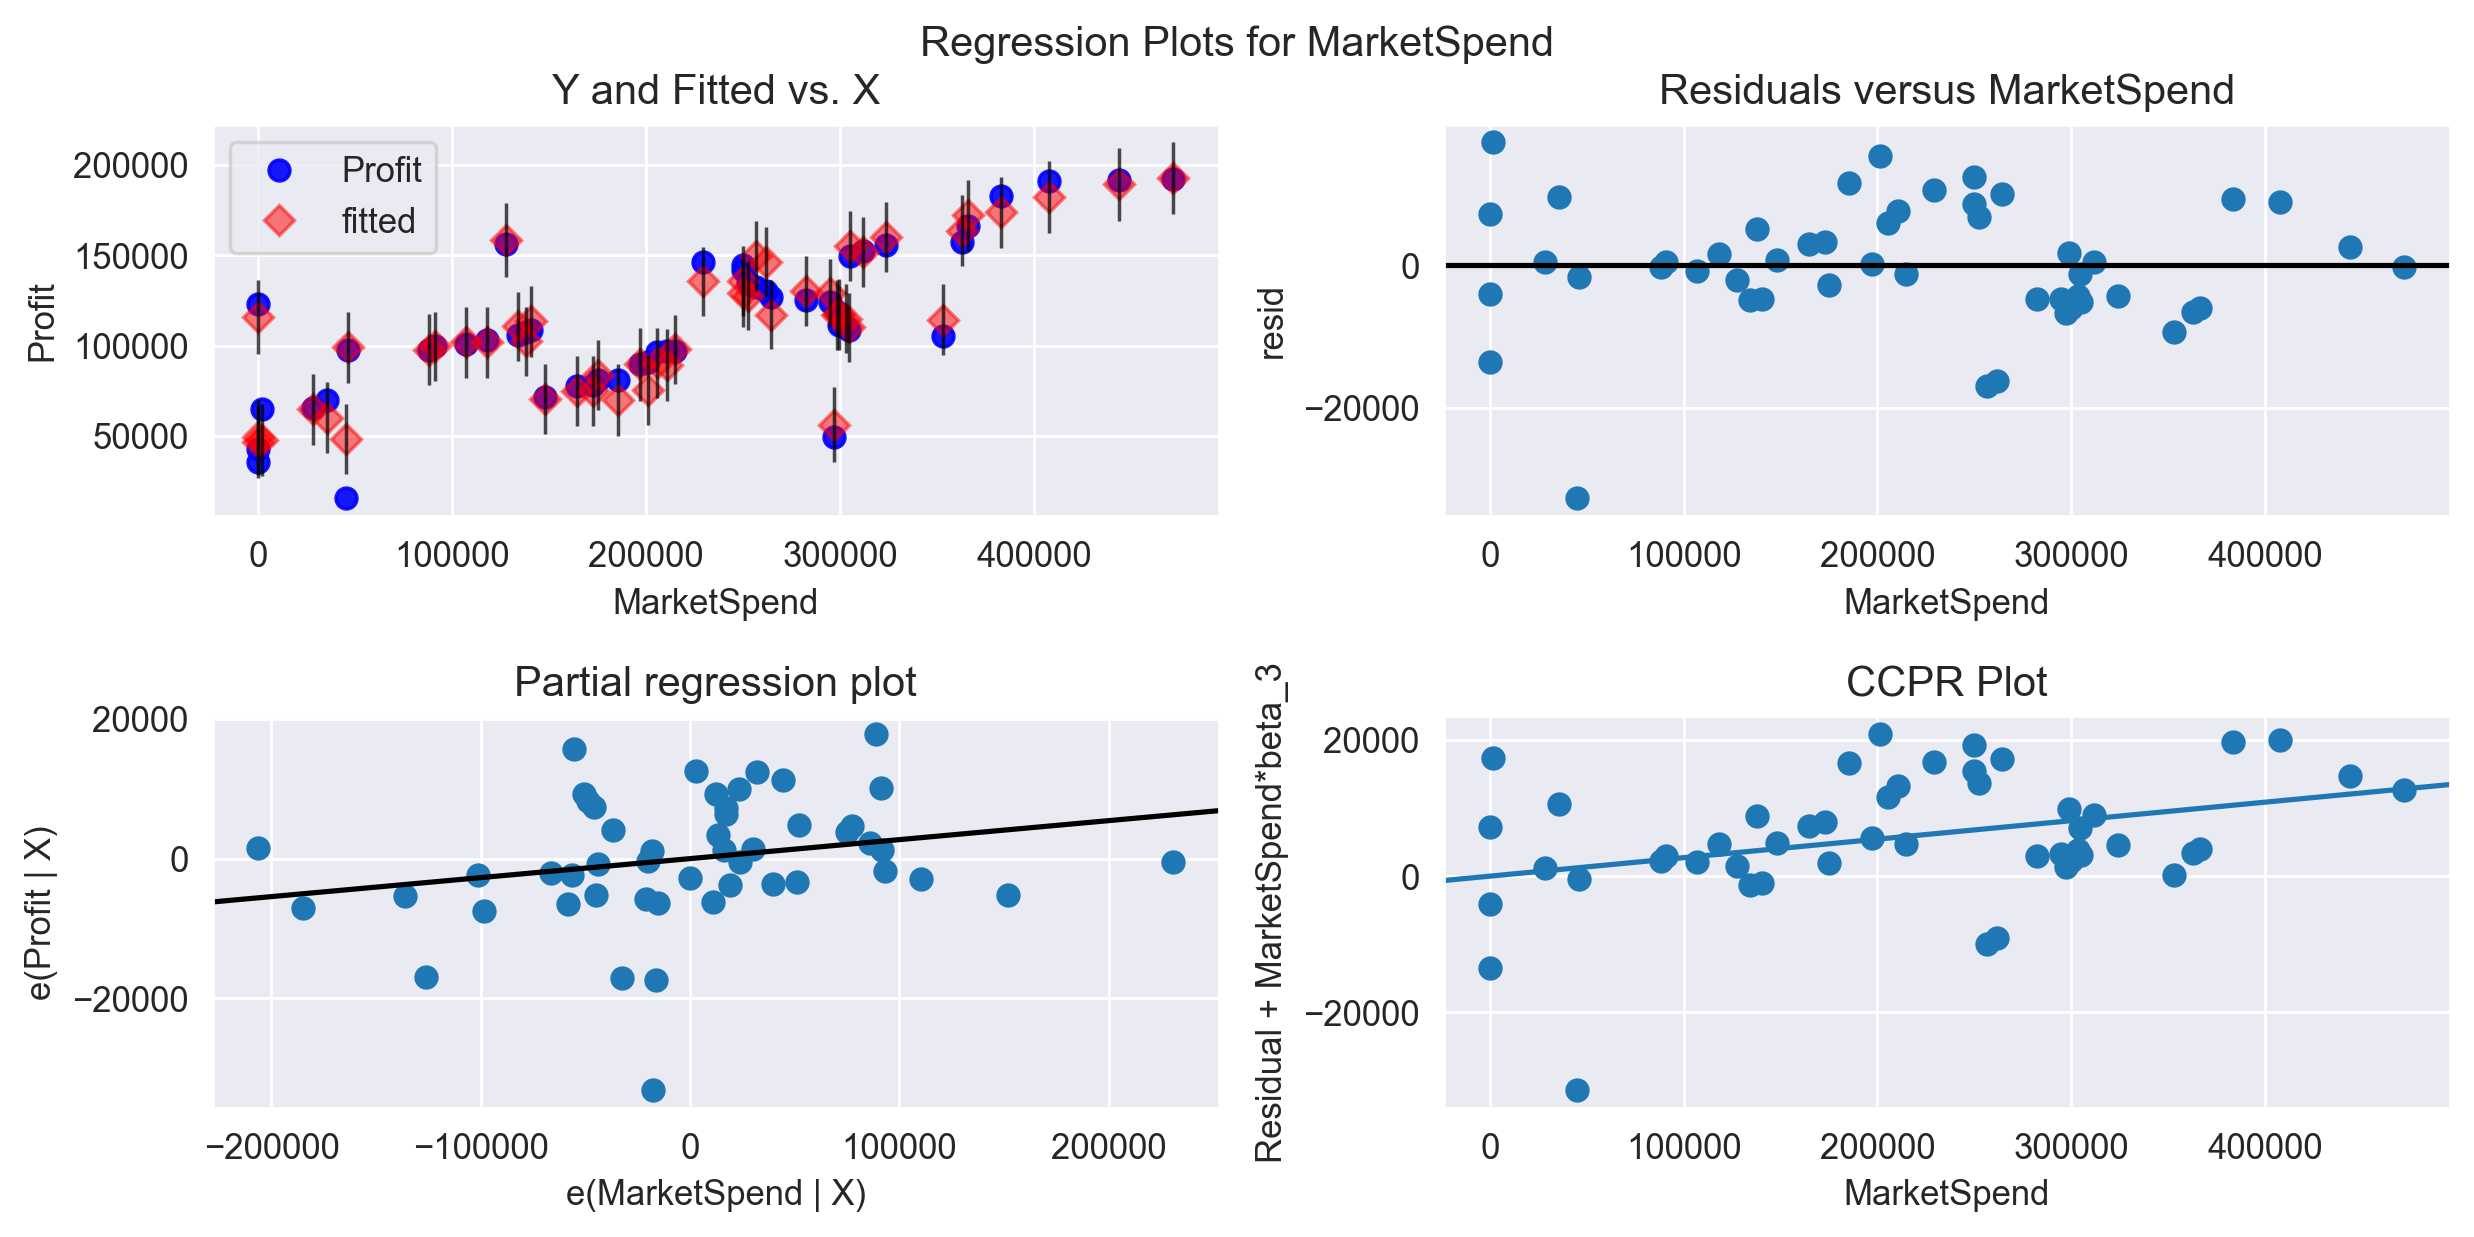

In [161]:
sm.graphics.plot_regress_exog(model,'MarketSpend');

eval_env: 1


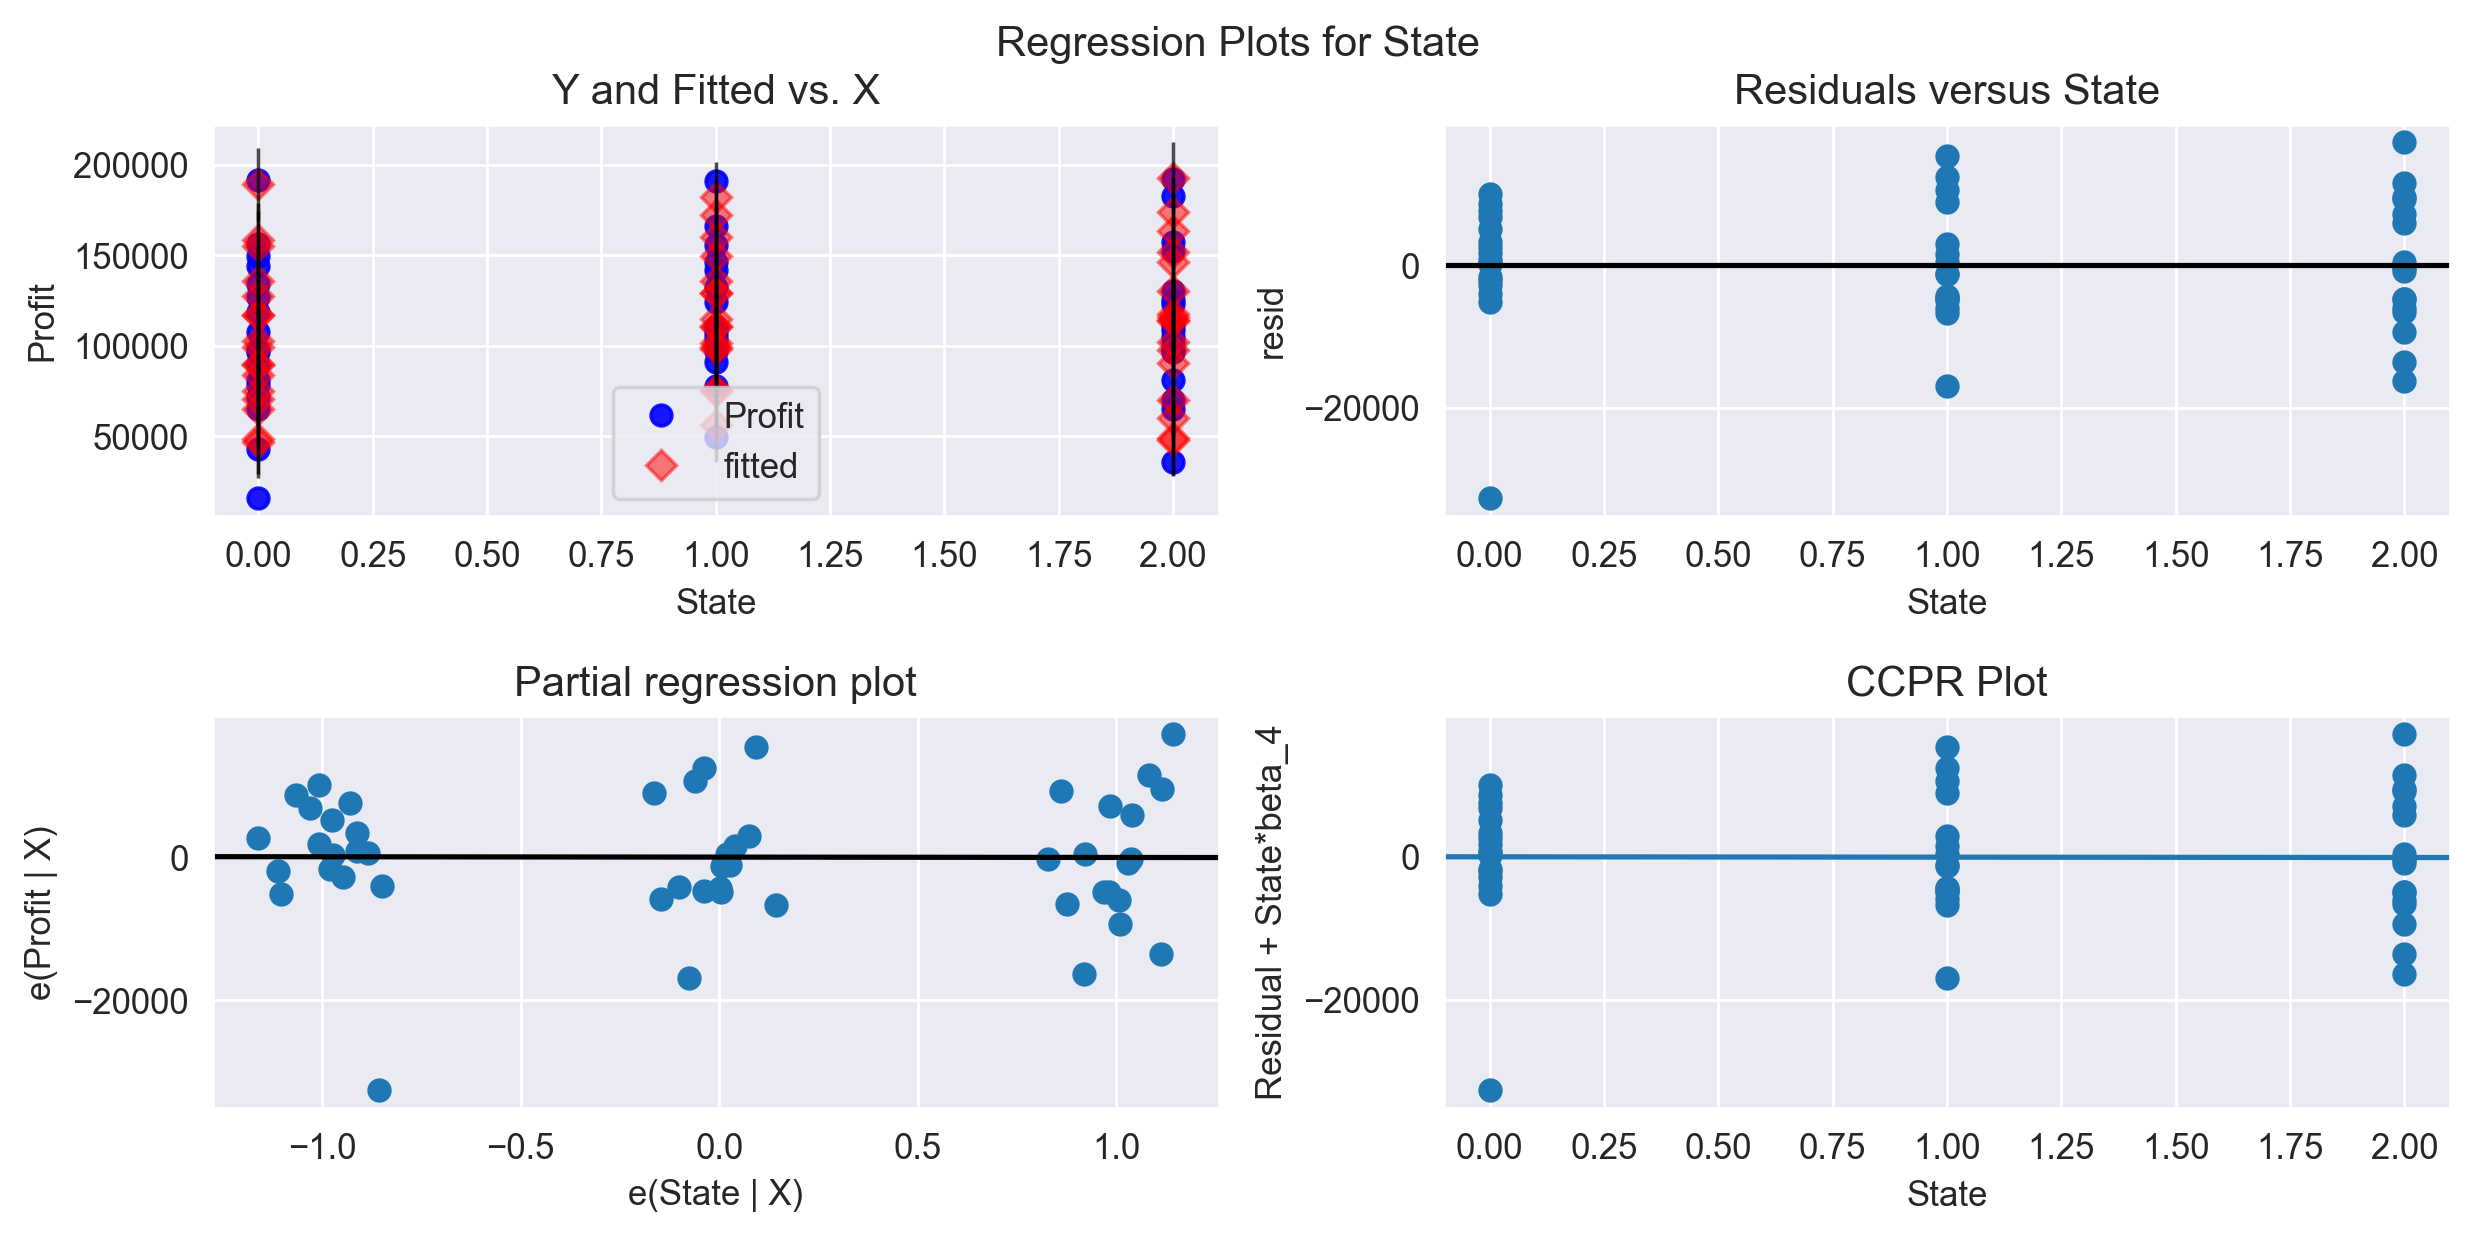

In [162]:
sm.graphics.plot_regress_exog(model,'State');

# MODEL DELETION TECHNIQUES

# Cook's Distance
   - **Detecting influencers and outliers**

In [163]:
inf = model.get_influence()
c,p = inf.cooks_distance

In [164]:
c

array([1.32360742e-05, 3.76231602e-03, 2.62349591e-02, 2.38851987e-02,
       1.15052524e-02, 1.24108197e-02, 3.22351857e-03, 2.83631195e-03,
       6.18320596e-05, 6.98145112e-03, 1.20566933e-02, 2.11127874e-02,
       9.20288525e-03, 7.16085211e-03, 4.89364273e-02, 4.61677371e-02,
       1.49282465e-02, 4.48188543e-03, 1.73269323e-03, 4.06035975e-02,
       5.92910778e-04, 1.24748496e-02, 2.33944010e-03, 2.25648051e-04,
       6.09400199e-03, 4.40919506e-03, 2.75251352e-03, 3.33362894e-02,
       1.00185145e-03, 1.57271331e-04, 2.89683274e-05, 1.05461276e-05,
       8.98541560e-04, 1.07201220e-04, 2.18047816e-02, 8.98385983e-03,
       4.41419321e-02, 3.86852164e-05, 6.33816490e-02, 1.97723733e-03,
       2.21273646e-03, 1.53200930e-03, 1.32102870e-04, 2.75683765e-02,
       8.43766632e-05, 1.13515240e-01, 4.43115391e-02, 5.80136267e-03,
       1.95686033e-01, 2.94556941e-01])

<StemContainer object of 3 artists>

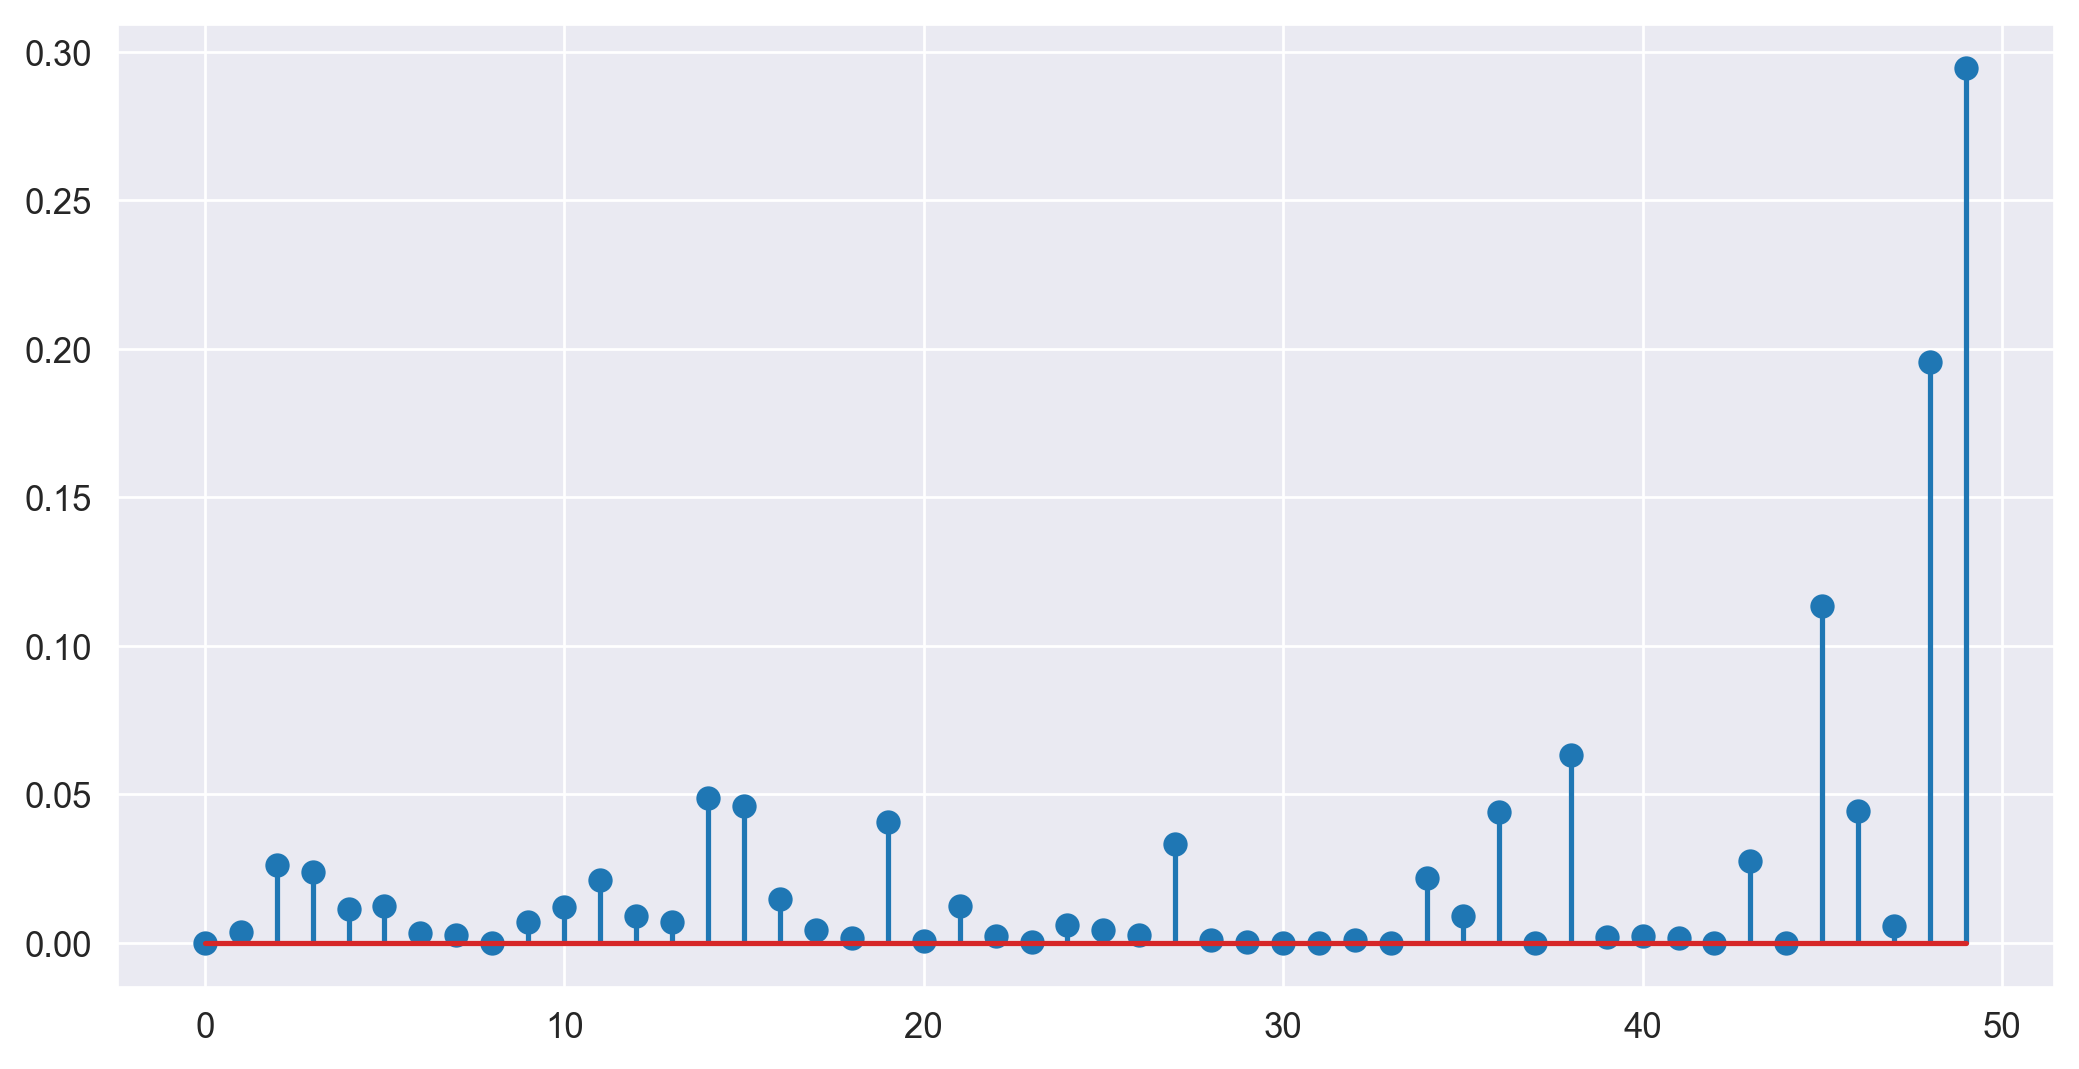

In [165]:
# Cook's distance plot
plt.stem(c)

In [166]:
#Priting index number of the influancing datapoint
np.argmax(c),np.max(c)

(49, 0.2945569410822932)

# Cook's distance value should not cross the value 1. In the above graph no datapoint crossing the threshold 1. Hence we are not dropping any values here.

# Influence Plot

The data point of index number 49 is considered as outlier or highly influence datapoint

In [167]:
#Influence Plot
from statsmodels.graphics.regressionplots import influence_plot

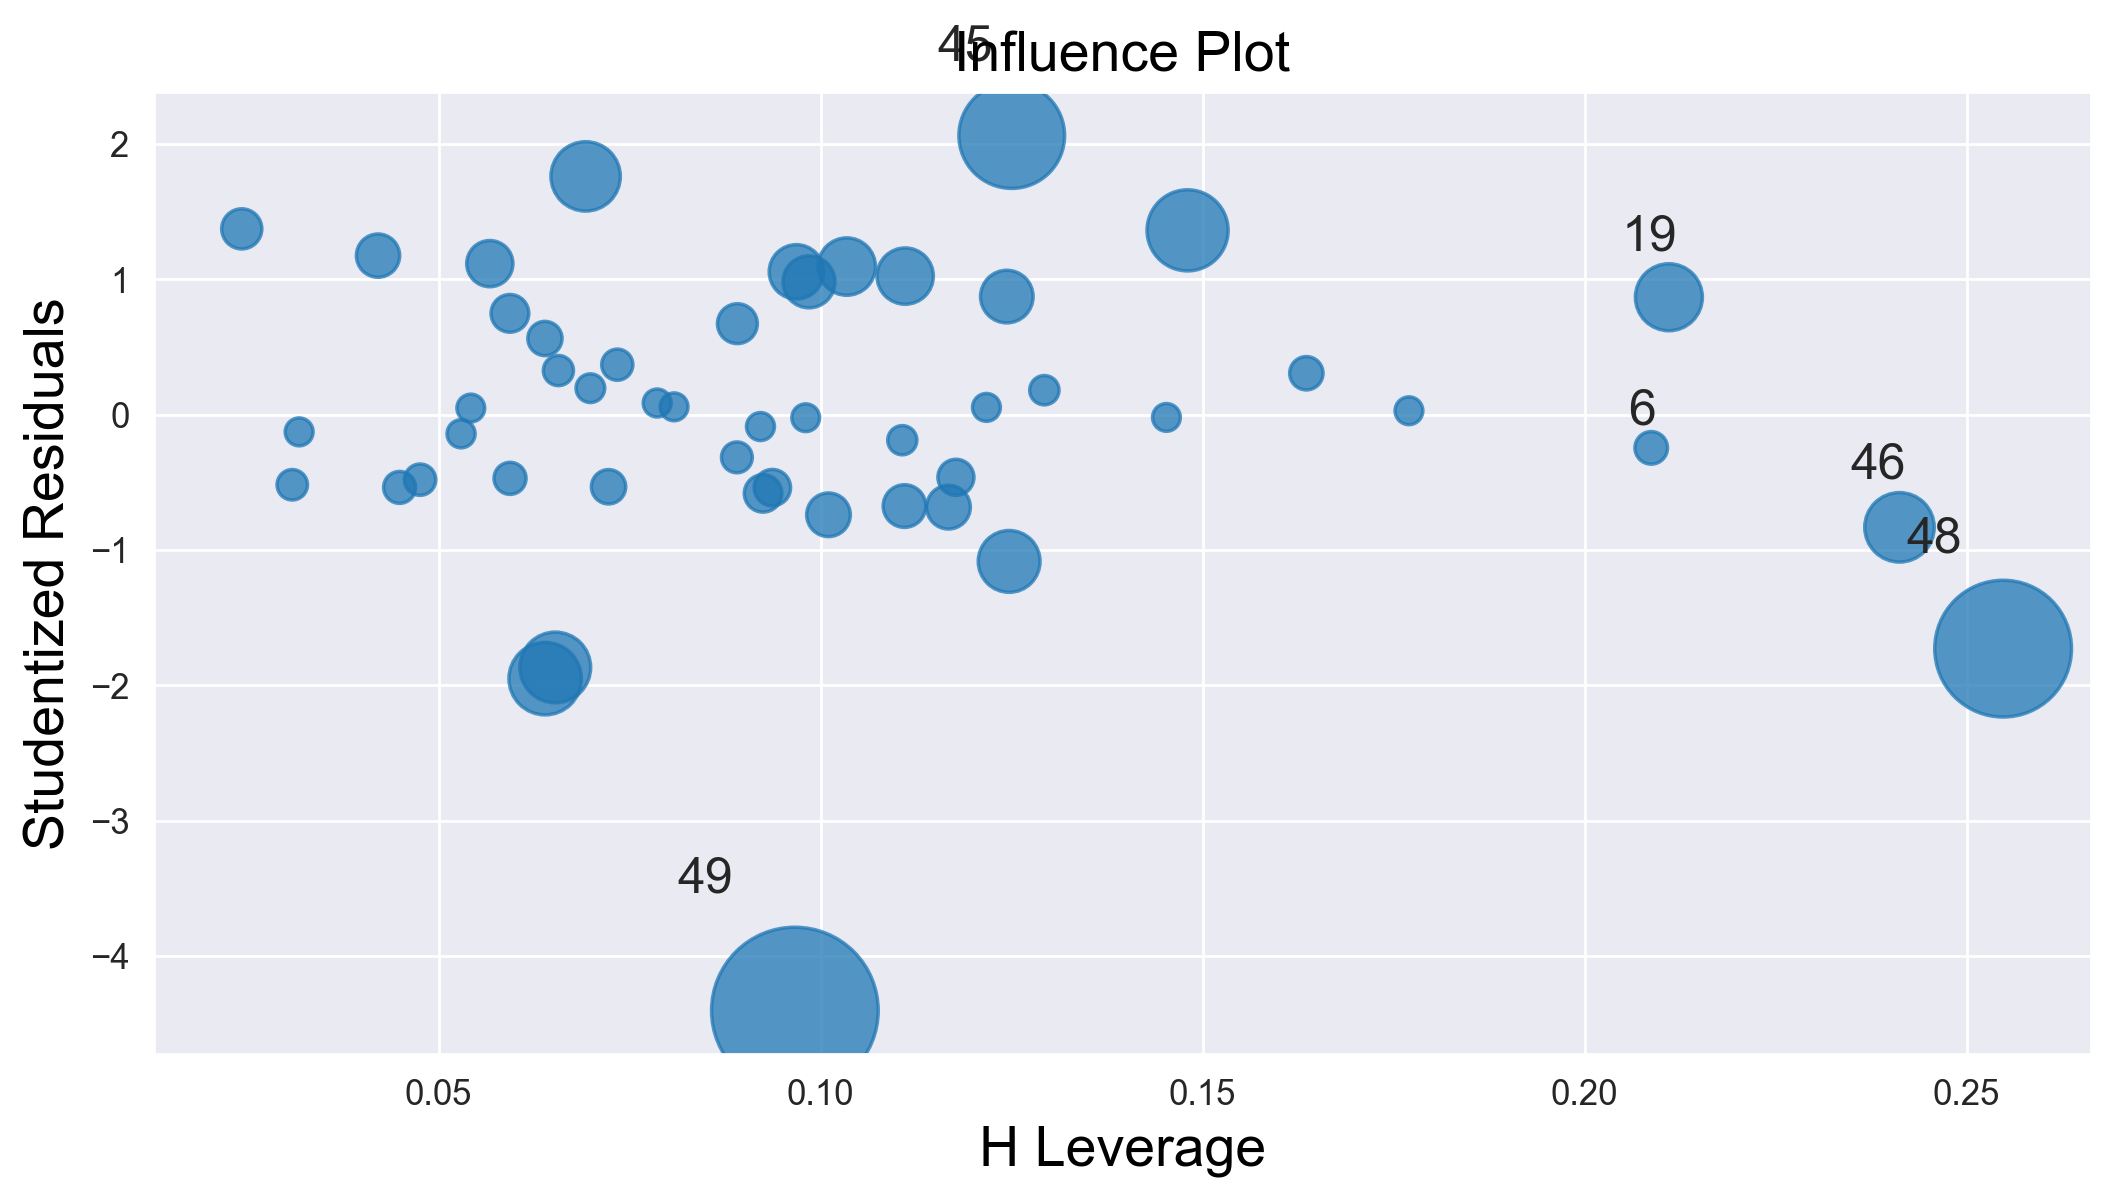

In [168]:
influence_plot(model);

In [169]:
#Calculate cutoff
k = len(df.columns)
n = len(df)

levarge_cutoff = 3*(k+1)/n
levarge_cutoff

0.36

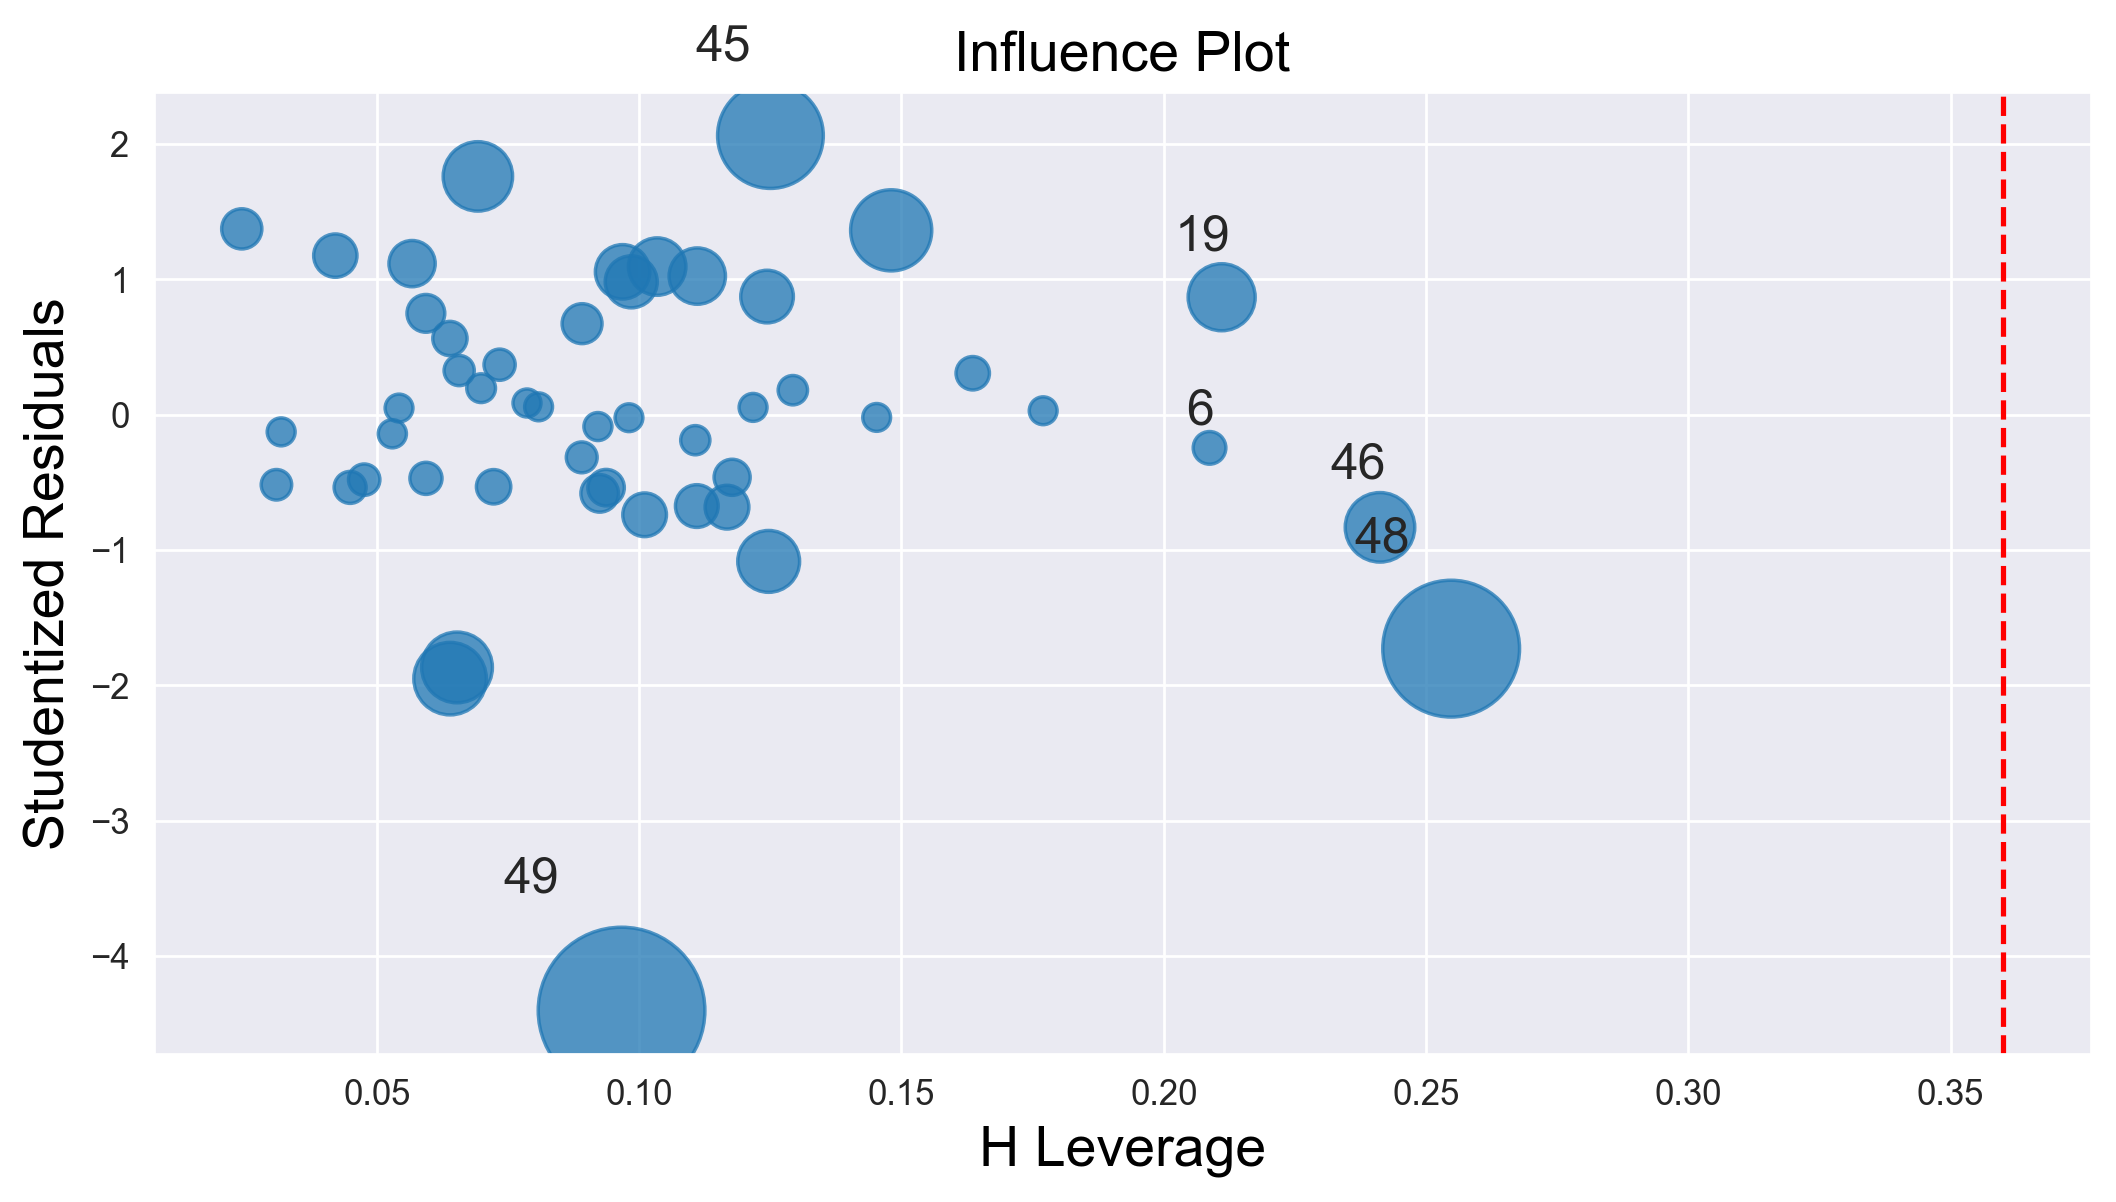

In [170]:
influence_plot(model)
plt.axvline(levarge_cutoff,color = 'red',linestyle = '--')

By using influence plot also we can conclude that there is no influence datapoint present